In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test flatfish can it turn?'
Experiment_note = """
"""

In [5]:
gpuId = 0
control_dt=0.2
theta = np.array([-180,180])
vel_theta = np.array([-45,45])
random_vel = np.array([0,0.3])
radius=1.0
max_time = 10
action_max= 10
done_dist = 0.15
dist_distri_param =np.array([0,0.1])
couple_mode =  fl.COUPLE_MODE.TWO_WAY
ratio = 0.005/control_dt*(max_time/10)
use_com=False

import torch
torch.cuda.set_device(gpuId)

In [6]:
wr = 0.0*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 0.5
live_penality =0

In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [8]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=1
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [256,256]
n_critics = 2
# actor settings
actor_net_arch= [256,256]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [9]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [10]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [11]:
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_flatfish.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_test.json
/root/pytorch_fish/py_data/jsons/rigids_flatfish.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [12]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [13]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [14]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [16]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

In [17]:
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,control_dt=control_dt,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
                   )
env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([1., 0., 0.])

In [18]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [19]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [20]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [21]:
step = 0
next_eval_steps= eval_frequency

In [22]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [23]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [24]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [25]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [26]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 39 | R: -99.3048 | D: 31.6 s | BR: -1.9217 | ALOSS: -4.1062 | CLOSS: 1.2158 | TLOSS: -0.0479 | TVAL: 0.9943 | AENT: -5.0000
| train | E: 2 | S: 73 | R: -45.5198 | D: 26.0 s | BR: -2.0102 | ALOSS: -4.4806 | CLOSS: 0.6641 | TLOSS: -0.1400 | TVAL: 0.9835 | AENT: -5.0000
| train | E: 3 | S: 115 | R: -67.4137 | D: 32.6 s | BR: -1.8464 | ALOSS: -4.8200 | CLOSS: 0.4947 | TLOSS: -0.2360 | TVAL: 0.9723 | AENT: -5.0000
| train | E: 4 | S: 165 | R: -77.1901 | D: 37.2 s | BR: -1.7475 | ALOSS: -5.0562 | CLOSS: 0.4249 | TLOSS: -0.3517 | TVAL: 0.9590 | AENT: -5.0000
| train | E: 5 | S: 215 | R: -99.0050 | D: 37.8 s | BR: -1.7996 | ALOSS: -5.1406 | CLOSS: 0.3879 | TLOSS: -0.4779 | TVAL: 0.9447 | AENT: -5.0000
| train | E: 6 | S: 248 | R: -64.8526 | D: 25.7 s | BR: -1.7948 | ALOSS: -5.2519 | CLOSS: 0.4427 | TLOSS: -0.5821 | TVAL: 0.9330 | AENT: -5.0000
| train | E: 7 | S: 298 | R: -104.7976 | D: 37.9 s | BR: -1.8140 | ALOSS: -5.3178 | CLOSS: 0.4818 | TLOSS: -0.6868 | TVAL: 0.9215 | 

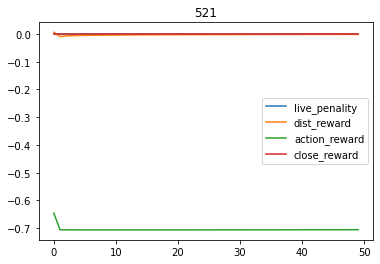

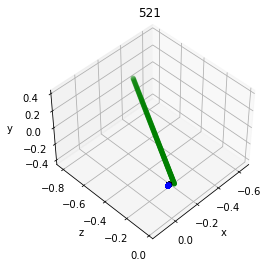

| eval  | E: 12 | S: 521 | R: -35.3771
| train | E: 13 | S: 521 | R: -55.4050 | D: 22.2 s | BR: -1.7896 | ALOSS: -5.9724 | CLOSS: 0.4094 | TLOSS: -1.2764 | TVAL: 0.8589 | AENT: -5.0000
| train | E: 14 | S: 563 | R: -72.5924 | D: 70.2 s | BR: -1.8008 | ALOSS: -6.0022 | CLOSS: 0.4935 | TLOSS: -1.3601 | TVAL: 0.8500 | AENT: -5.0000
| train | E: 15 | S: 612 | R: -105.1436 | D: 37.6 s | BR: -1.8226 | ALOSS: -6.0633 | CLOSS: 0.5178 | TLOSS: -1.4757 | TVAL: 0.8385 | AENT: -5.0000
| train | E: 16 | S: 662 | R: -106.1595 | D: 40.0 s | BR: -1.8240 | ALOSS: -6.0589 | CLOSS: 0.5089 | TLOSS: -1.5998 | TVAL: 0.8262 | AENT: -5.0000
| train | E: 17 | S: 699 | R: -71.9813 | D: 30.3 s | BR: -1.8427 | ALOSS: -6.0858 | CLOSS: 0.4210 | TLOSS: -1.7065 | TVAL: 0.8155 | AENT: -5.0000
| train | E: 18 | S: 738 | R: -62.3420 | D: 30.4 s | BR: -1.8349 | ALOSS: -6.1457 | CLOSS: 0.4474 | TLOSS: -1.8034 | TVAL: 0.8063 | AENT: -5.0000
| train | E: 19 | S: 788 | R: -107.3567 | D: 38.1 s | BR: -1.8385 | ALOSS: -6.1963 

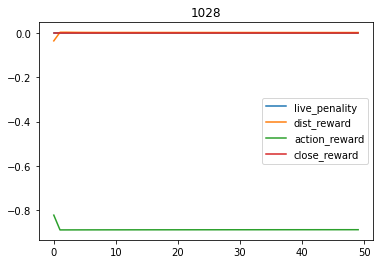

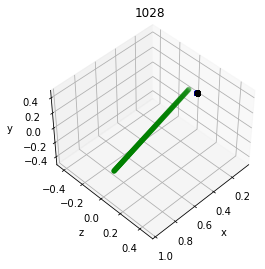

| eval  | E: 23 | S: 1028 | R: -44.2541
| train | E: 24 | S: 1028 | R: -69.0270 | D: 38.2 s | BR: -1.8794 | ALOSS: -6.0948 | CLOSS: 0.4581 | TLOSS: -2.5113 | TVAL: 0.7404 | AENT: -5.0000
| train | E: 25 | S: 1058 | R: -59.3585 | D: 61.9 s | BR: -1.8582 | ALOSS: -6.2317 | CLOSS: 0.3622 | TLOSS: -2.6020 | TVAL: 0.7316 | AENT: -5.0000
| train | E: 26 | S: 1098 | R: -74.7911 | D: 30.5 s | BR: -1.8531 | ALOSS: -6.2218 | CLOSS: 0.4942 | TLOSS: -2.6971 | TVAL: 0.7240 | AENT: -5.0000
| train | E: 27 | S: 1148 | R: -99.3720 | D: 40.3 s | BR: -1.8772 | ALOSS: -6.1563 | CLOSS: 0.4065 | TLOSS: -2.8052 | TVAL: 0.7144 | AENT: -5.0000
| train | E: 28 | S: 1198 | R: -101.1816 | D: 38.4 s | BR: -1.8741 | ALOSS: -6.1467 | CLOSS: 0.7021 | TLOSS: -2.9289 | TVAL: 0.7038 | AENT: -5.0000
| train | E: 29 | S: 1243 | R: -76.2616 | D: 36.6 s | BR: -1.8554 | ALOSS: -6.2679 | CLOSS: 0.4780 | TLOSS: -3.0493 | TVAL: 0.6938 | AENT: -5.0000
| train | E: 30 | S: 1293 | R: -73.4840 | D: 38.5 s | BR: -1.8617 | ALOSS: -6

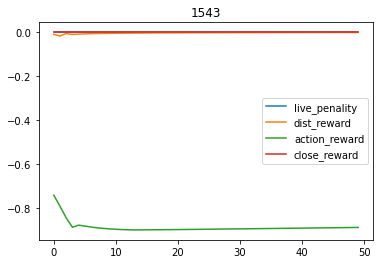

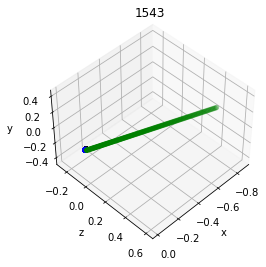

| eval  | E: 34 | S: 1543 | R: -44.4191
| train | E: 35 | S: 1543 | R: -84.7807 | D: 37.9 s | BR: -1.8852 | ALOSS: -5.8664 | CLOSS: 0.6452 | TLOSS: -3.7866 | TVAL: 0.6348 | AENT: -5.0000
| train | E: 36 | S: 1593 | R: -97.3902 | D: 76.9 s | BR: -1.8731 | ALOSS: -5.8486 | CLOSS: 0.5317 | TLOSS: -3.9146 | TVAL: 0.6254 | AENT: -5.0000
| train | E: 37 | S: 1642 | R: -79.0289 | D: 37.1 s | BR: -1.8776 | ALOSS: -5.8088 | CLOSS: 0.7677 | TLOSS: -4.0251 | TVAL: 0.6162 | AENT: -5.0000
| train | E: 38 | S: 1692 | R: -91.5433 | D: 38.0 s | BR: -1.8717 | ALOSS: -5.7555 | CLOSS: 0.6856 | TLOSS: -4.1504 | TVAL: 0.6072 | AENT: -5.0000
| train | E: 39 | S: 1742 | R: -103.8864 | D: 39.4 s | BR: -1.8740 | ALOSS: -5.6214 | CLOSS: 0.7159 | TLOSS: -4.2651 | TVAL: 0.5982 | AENT: -5.0000
| train | E: 40 | S: 1779 | R: -61.8357 | D: 28.2 s | BR: -1.8519 | ALOSS: -5.7692 | CLOSS: 0.5805 | TLOSS: -4.3674 | TVAL: 0.5904 | AENT: -5.0000
| train | E: 41 | S: 1829 | R: -85.3676 | D: 39.5 s | BR: -1.8647 | ALOSS: -5

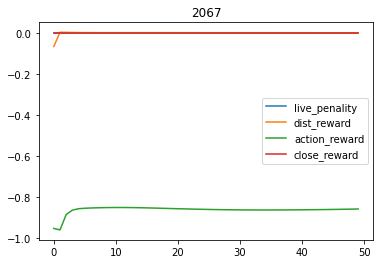

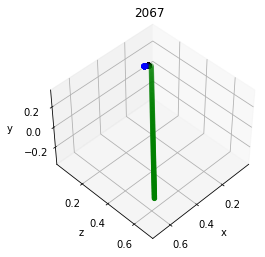

| eval  | E: 46 | S: 2067 | R: -43.0276
| train | E: 47 | S: 2067 | R: -81.1495 | D: 35.4 s | BR: -1.8384 | ALOSS: -5.0409 | CLOSS: 0.7555 | TLOSS: -5.0534 | TVAL: 0.5427 | AENT: -5.0000
| train | E: 48 | S: 2094 | R: -55.6406 | D: 59.8 s | BR: -1.8331 | ALOSS: -4.9526 | CLOSS: 0.5925 | TLOSS: -5.1124 | TVAL: 0.5368 | AENT: -5.0000
| train | E: 49 | S: 2144 | R: -89.7205 | D: 37.8 s | BR: -1.8335 | ALOSS: -4.9136 | CLOSS: 0.7688 | TLOSS: -5.2304 | TVAL: 0.5307 | AENT: -5.0000
| train | E: 50 | S: 2194 | R: -89.3786 | D: 38.0 s | BR: -1.8275 | ALOSS: -4.7402 | CLOSS: 0.7816 | TLOSS: -5.3451 | TVAL: 0.5228 | AENT: -5.0000
| train | E: 51 | S: 2244 | R: -70.6024 | D: 38.0 s | BR: -1.8344 | ALOSS: -4.5275 | CLOSS: 0.6606 | TLOSS: -5.4776 | TVAL: 0.5151 | AENT: -5.0000
| train | E: 52 | S: 2294 | R: -67.2999 | D: 39.9 s | BR: -1.8296 | ALOSS: -4.4836 | CLOSS: 0.9454 | TLOSS: -5.5806 | TVAL: 0.5075 | AENT: -5.0000
| train | E: 53 | S: 2344 | R: -65.7254 | D: 37.8 s | BR: -1.8075 | ALOSS: -4.

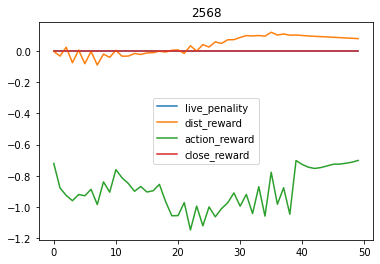

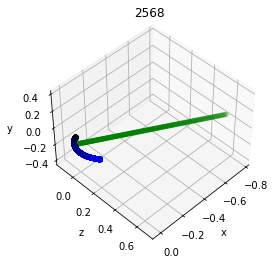

| eval  | E: 57 | S: 2568 | R: -42.8729
| train | E: 58 | S: 2568 | R: -55.6720 | D: 27.3 s | BR: -1.7983 | ALOSS: -3.8137 | CLOSS: 0.7393 | TLOSS: -6.2548 | TVAL: 0.4668 | AENT: -5.0000
| train | E: 59 | S: 2618 | R: -98.6690 | D: 77.3 s | BR: -1.7877 | ALOSS: -3.7344 | CLOSS: 0.6974 | TLOSS: -6.3407 | TVAL: 0.4609 | AENT: -5.0000
| train | E: 60 | S: 2668 | R: -66.9768 | D: 37.6 s | BR: -1.7873 | ALOSS: -3.5574 | CLOSS: 0.7329 | TLOSS: -6.4599 | TVAL: 0.4541 | AENT: -5.0000
| train | E: 61 | S: 2718 | R: -70.5074 | D: 38.7 s | BR: -1.7980 | ALOSS: -3.3983 | CLOSS: 0.5596 | TLOSS: -6.5717 | TVAL: 0.4474 | AENT: -5.0000
| train | E: 62 | S: 2768 | R: -66.2489 | D: 38.1 s | BR: -1.7833 | ALOSS: -3.2605 | CLOSS: 0.6166 | TLOSS: -6.6896 | TVAL: 0.4409 | AENT: -5.0000
| train | E: 63 | S: 2805 | R: -56.7367 | D: 28.4 s | BR: -1.7729 | ALOSS: -3.2674 | CLOSS: 0.5030 | TLOSS: -6.8057 | TVAL: 0.4352 | AENT: -5.0000
| train | E: 64 | S: 2855 | R: -92.8482 | D: 39.7 s | BR: -1.7705 | ALOSS: -3.

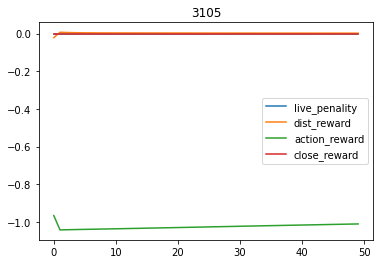

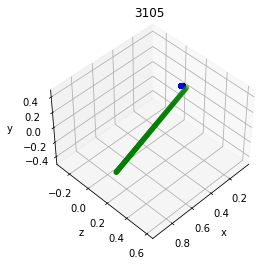

| eval  | E: 68 | S: 3105 | R: -51.1087
| train | E: 69 | S: 3105 | R: -89.3205 | D: 38.4 s | BR: -1.7352 | ALOSS: -2.4878 | CLOSS: 0.6756 | TLOSS: -7.4133 | TVAL: 0.3991 | AENT: -5.0000
| train | E: 70 | S: 3148 | R: -53.0689 | D: 72.5 s | BR: -1.7482 | ALOSS: -2.1640 | CLOSS: 0.7247 | TLOSS: -7.5215 | TVAL: 0.3936 | AENT: -5.0000
| train | E: 71 | S: 3181 | R: -33.5485 | D: 25.7 s | BR: -1.7395 | ALOSS: -2.0920 | CLOSS: 0.5856 | TLOSS: -7.6015 | TVAL: 0.3892 | AENT: -5.0000
| train | E: 72 | S: 3231 | R: -80.7743 | D: 38.7 s | BR: -1.7332 | ALOSS: -2.0318 | CLOSS: 0.7148 | TLOSS: -7.6820 | TVAL: 0.3845 | AENT: -5.0000
| train | E: 73 | S: 3273 | R: -64.5224 | D: 31.8 s | BR: -1.7040 | ALOSS: -2.0491 | CLOSS: 0.5973 | TLOSS: -7.7630 | TVAL: 0.3794 | AENT: -5.0000
| train | E: 74 | S: 3323 | R: -66.4070 | D: 38.7 s | BR: -1.7252 | ALOSS: -1.8411 | CLOSS: 0.6534 | TLOSS: -7.8411 | TVAL: 0.3743 | AENT: -5.0000
| train | E: 75 | S: 3373 | R: -65.8458 | D: 38.3 s | BR: -1.7440 | ALOSS: -1.

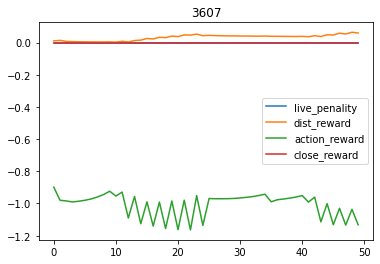

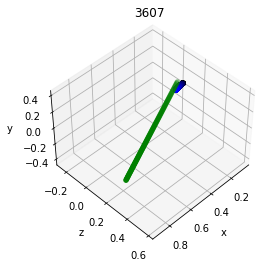

| eval  | E: 79 | S: 3607 | R: -48.7328
| train | E: 80 | S: 3607 | R: -73.9842 | D: 38.1 s | BR: -1.7280 | ALOSS: -0.6564 | CLOSS: 0.6302 | TLOSS: -8.4378 | TVAL: 0.3444 | AENT: -5.0000
| train | E: 81 | S: 3657 | R: -63.3428 | D: 76.7 s | BR: -1.7121 | ALOSS: -0.6546 | CLOSS: 0.6286 | TLOSS: -8.5468 | TVAL: 0.3394 | AENT: -5.0000
| train | E: 82 | S: 3707 | R: -67.8712 | D: 38.6 s | BR: -1.7109 | ALOSS: -0.4130 | CLOSS: 0.7152 | TLOSS: -8.6216 | TVAL: 0.3345 | AENT: -5.0000
| train | E: 83 | S: 3747 | R: -64.9300 | D: 30.7 s | BR: -1.6924 | ALOSS: -0.3348 | CLOSS: 0.7622 | TLOSS: -8.7021 | TVAL: 0.3301 | AENT: -5.0000
| train | E: 84 | S: 3797 | R: -60.9724 | D: 38.4 s | BR: -1.6811 | ALOSS: -0.4125 | CLOSS: 0.8083 | TLOSS: -8.7987 | TVAL: 0.3259 | AENT: -5.0000
| train | E: 85 | S: 3847 | R: -65.2288 | D: 39.3 s | BR: -1.6891 | ALOSS: -0.1490 | CLOSS: 0.6935 | TLOSS: -8.8918 | TVAL: 0.3211 | AENT: -5.0000
| train | E: 86 | S: 3897 | R: -73.1715 | D: 38.0 s | BR: -1.6712 | ALOSS: -0.

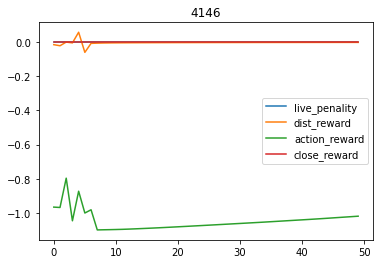

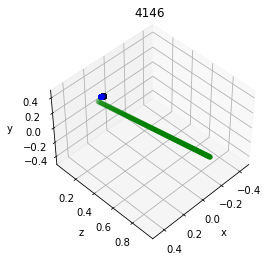

| eval  | E: 90 | S: 4146 | R: -52.5687
| train | E: 91 | S: 4146 | R: -54.3524 | D: 37.5 s | BR: -1.6753 | ALOSS: 0.8681 | CLOSS: 0.7095 | TLOSS: -9.3800 | TVAL: 0.2945 | AENT: -5.0000
| train | E: 92 | S: 4196 | R: -87.2229 | D: 78.2 s | BR: -1.6588 | ALOSS: 1.0313 | CLOSS: 0.8457 | TLOSS: -9.5272 | TVAL: 0.2903 | AENT: -5.0000
| train | E: 93 | S: 4246 | R: -96.4627 | D: 38.3 s | BR: -1.6885 | ALOSS: 1.3162 | CLOSS: 0.7855 | TLOSS: -9.5073 | TVAL: 0.2861 | AENT: -5.0000
| train | E: 94 | S: 4296 | R: -66.6528 | D: 39.3 s | BR: -1.6591 | ALOSS: 1.3929 | CLOSS: 0.8313 | TLOSS: -9.6752 | TVAL: 0.2820 | AENT: -5.0000
| train | E: 95 | S: 4346 | R: -56.4222 | D: 40.0 s | BR: -1.6452 | ALOSS: 1.6166 | CLOSS: 0.7031 | TLOSS: -9.7380 | TVAL: 0.2780 | AENT: -5.0000
| train | E: 96 | S: 4396 | R: -66.9931 | D: 38.2 s | BR: -1.6515 | ALOSS: 1.6631 | CLOSS: 0.8321 | TLOSS: -9.7841 | TVAL: 0.2740 | AENT: -5.0000
| train | E: 97 | S: 4441 | R: -50.9644 | D: 33.9 s | BR: -1.6336 | ALOSS: 1.7712 | 

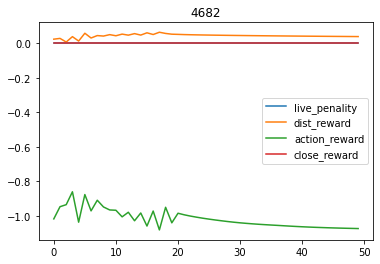

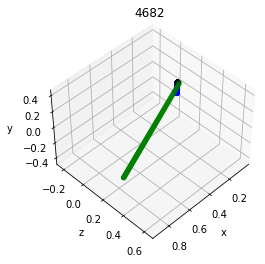

| eval  | E: 101 | S: 4682 | R: -48.7258
| train | E: 102 | S: 4682 | R: -61.6009 | D: 38.1 s | BR: -1.6253 | ALOSS: 2.5652 | CLOSS: 0.8169 | TLOSS: -10.2474 | TVAL: 0.2524 | AENT: -5.0000
| train | E: 103 | S: 4732 | R: -60.6249 | D: 75.9 s | BR: -1.6273 | ALOSS: 2.8586 | CLOSS: 0.9482 | TLOSS: -10.3145 | TVAL: 0.2489 | AENT: -5.0000
| train | E: 104 | S: 4781 | R: -102.4288 | D: 37.3 s | BR: -1.6184 | ALOSS: 2.7930 | CLOSS: 1.0071 | TLOSS: -10.4374 | TVAL: 0.2454 | AENT: -5.0000
| train | E: 105 | S: 4828 | R: -52.7713 | D: 35.5 s | BR: -1.6331 | ALOSS: 3.3250 | CLOSS: 0.9665 | TLOSS: -10.4275 | TVAL: 0.2420 | AENT: -5.0000
| train | E: 106 | S: 4878 | R: -66.2343 | D: 37.9 s | BR: -1.6182 | ALOSS: 3.2494 | CLOSS: 0.8742 | TLOSS: -10.5377 | TVAL: 0.2387 | AENT: -5.0000
| train | E: 107 | S: 4928 | R: -95.3075 | D: 37.9 s | BR: -1.6334 | ALOSS: 3.5353 | CLOSS: 1.1413 | TLOSS: -10.6569 | TVAL: 0.2353 | AENT: -5.0000
| train | E: 108 | S: 4978 | R: -57.9059 | D: 40.5 s | BR: -1.6212 | A

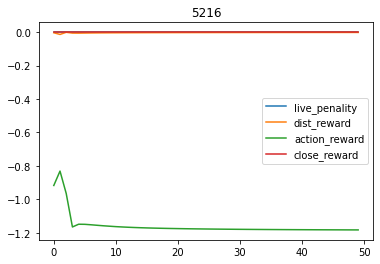

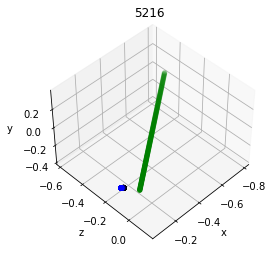

| eval  | E: 112 | S: 5216 | R: -58.0562
| train | E: 113 | S: 5216 | R: -55.6240 | D: 37.7 s | BR: -1.5854 | ALOSS: 4.5371 | CLOSS: 1.1660 | TLOSS: -11.0007 | TVAL: 0.2168 | AENT: -5.0000
| train | E: 114 | S: 5266 | R: -64.2609 | D: 78.8 s | BR: -1.5854 | ALOSS: 4.5835 | CLOSS: 1.1644 | TLOSS: -11.0610 | TVAL: 0.2137 | AENT: -5.0000
| train | E: 115 | S: 5312 | R: -47.2357 | D: 35.0 s | BR: -1.5898 | ALOSS: 4.8293 | CLOSS: 0.7931 | TLOSS: -11.2053 | TVAL: 0.2108 | AENT: -5.0000
| train | E: 116 | S: 5362 | R: -60.8114 | D: 38.2 s | BR: -1.5861 | ALOSS: 4.9136 | CLOSS: 1.0717 | TLOSS: -11.1970 | TVAL: 0.2079 | AENT: -5.0000
| train | E: 117 | S: 5412 | R: -55.2450 | D: 38.4 s | BR: -1.5973 | ALOSS: 5.5171 | CLOSS: 0.9646 | TLOSS: -11.3280 | TVAL: 0.2050 | AENT: -5.0000
| train | E: 118 | S: 5458 | R: -45.1444 | D: 34.9 s | BR: -1.5657 | ALOSS: 5.3413 | CLOSS: 1.5734 | TLOSS: -11.3837 | TVAL: 0.2022 | AENT: -5.0000
| train | E: 119 | S: 5508 | R: -53.0500 | D: 38.3 s | BR: -1.5791 | AL

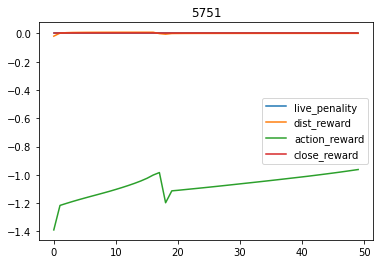

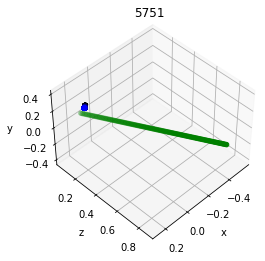

| eval  | E: 123 | S: 5751 | R: -53.7025
| train | E: 124 | S: 5751 | R: -61.3458 | D: 38.2 s | BR: -1.5530 | ALOSS: 6.0373 | CLOSS: 1.4481 | TLOSS: -11.5809 | TVAL: 0.1863 | AENT: -5.0000
| train | E: 125 | S: 5801 | R: -52.9124 | D: 76.7 s | BR: -1.5399 | ALOSS: 6.2034 | CLOSS: 1.3450 | TLOSS: -11.6603 | TVAL: 0.1837 | AENT: -5.0000
| train | E: 126 | S: 5848 | R: -48.9273 | D: 37.0 s | BR: -1.5552 | ALOSS: 6.5980 | CLOSS: 1.1304 | TLOSS: -11.7390 | TVAL: 0.1812 | AENT: -5.0000
| train | E: 127 | S: 5898 | R: -83.1772 | D: 38.6 s | BR: -1.5467 | ALOSS: 6.7948 | CLOSS: 1.2952 | TLOSS: -11.7538 | TVAL: 0.1788 | AENT: -5.0000
| train | E: 128 | S: 5948 | R: -75.5712 | D: 39.1 s | BR: -1.5370 | ALOSS: 6.9052 | CLOSS: 1.1325 | TLOSS: -11.8735 | TVAL: 0.1763 | AENT: -5.0000
| train | E: 129 | S: 5998 | R: -58.9516 | D: 38.3 s | BR: -1.5505 | ALOSS: 7.0484 | CLOSS: 1.5796 | TLOSS: -11.9074 | TVAL: 0.1738 | AENT: -5.0000
| train | E: 130 | S: 6048 | R: -54.6441 | D: 37.7 s | BR: -1.5472 | AL

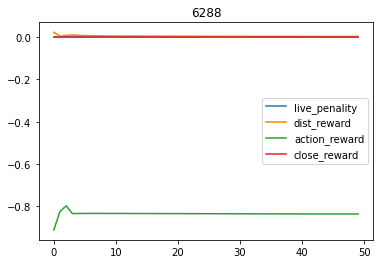

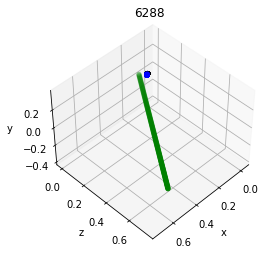

| eval  | E: 134 | S: 6288 | R: -41.5432
| train | E: 135 | S: 6288 | R: -53.5809 | D: 38.2 s | BR: -1.5246 | ALOSS: 7.8514 | CLOSS: 2.0646 | TLOSS: -12.0513 | TVAL: 0.1603 | AENT: -5.0000
| train | E: 136 | S: 6330 | R: -40.1390 | D: 70.5 s | BR: -1.5286 | ALOSS: 8.1418 | CLOSS: 1.5118 | TLOSS: -12.1088 | TVAL: 0.1583 | AENT: -5.0000
| train | E: 137 | S: 6380 | R: -51.6819 | D: 37.9 s | BR: -1.5188 | ALOSS: 8.3311 | CLOSS: 1.7976 | TLOSS: -12.2009 | TVAL: 0.1563 | AENT: -5.0000
| train | E: 138 | S: 6430 | R: -64.9431 | D: 38.0 s | BR: -1.5309 | ALOSS: 8.5736 | CLOSS: 1.4852 | TLOSS: -12.2990 | TVAL: 0.1541 | AENT: -5.0000
| train | E: 139 | S: 6480 | R: -51.3697 | D: 38.3 s | BR: -1.5078 | ALOSS: 8.5111 | CLOSS: 1.6872 | TLOSS: -12.4468 | TVAL: 0.1519 | AENT: -5.0000
| train | E: 140 | S: 6530 | R: -47.4402 | D: 38.0 s | BR: -1.5094 | ALOSS: 8.5937 | CLOSS: 1.5583 | TLOSS: -12.4566 | TVAL: 0.1498 | AENT: -5.0000
| train | E: 141 | S: 6580 | R: -69.6070 | D: 38.0 s | BR: -1.5008 | AL

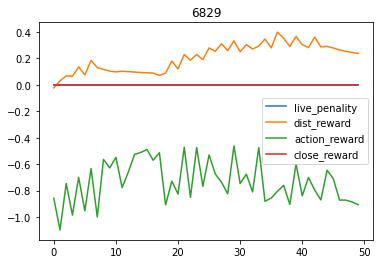

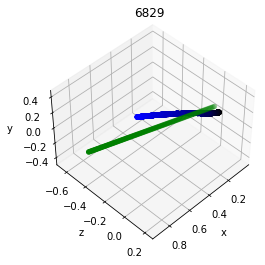

| eval  | E: 145 | S: 6829 | R: -26.3521
| train | E: 146 | S: 6829 | R: -48.2371 | D: 38.4 s | BR: -1.5065 | ALOSS: 9.6828 | CLOSS: 1.6593 | TLOSS: -12.4585 | TVAL: 0.1378 | AENT: -5.0000
| train | E: 147 | S: 6879 | R: -47.0857 | D: 77.3 s | BR: -1.4894 | ALOSS: 9.6584 | CLOSS: 1.8308 | TLOSS: -12.6828 | TVAL: 0.1360 | AENT: -5.0000
| train | E: 148 | S: 6929 | R: -64.8343 | D: 38.4 s | BR: -1.4886 | ALOSS: 9.9079 | CLOSS: 2.1209 | TLOSS: -12.6206 | TVAL: 0.1341 | AENT: -5.0000
| train | E: 149 | S: 6979 | R: -45.8259 | D: 37.9 s | BR: -1.4628 | ALOSS: 9.7362 | CLOSS: 2.1802 | TLOSS: -12.6925 | TVAL: 0.1323 | AENT: -5.0000
| train | E: 150 | S: 7029 | R: -61.0391 | D: 38.4 s | BR: -1.4773 | ALOSS: 10.1358 | CLOSS: 2.2729 | TLOSS: -12.7758 | TVAL: 0.1304 | AENT: -5.0000
| train | E: 151 | S: 7074 | R: -42.7676 | D: 38.8 s | BR: -1.4823 | ALOSS: 10.1606 | CLOSS: 2.0474 | TLOSS: -12.4280 | TVAL: 0.1287 | AENT: -5.0000
| train | E: 152 | S: 7124 | R: -48.8764 | D: 39.1 s | BR: -1.4607 | 

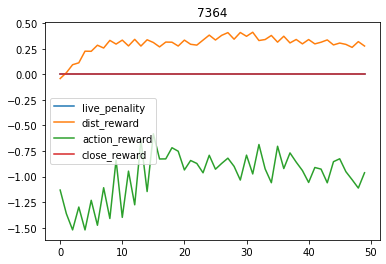

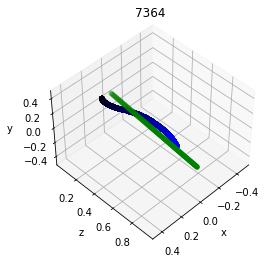

| eval  | E: 156 | S: 7364 | R: -34.4337
| train | E: 157 | S: 7364 | R: -58.7271 | D: 38.0 s | BR: -1.4578 | ALOSS: 11.0215 | CLOSS: 1.8267 | TLOSS: -12.5469 | TVAL: 0.1191 | AENT: -5.0000
| train | E: 158 | S: 7406 | R: -35.2039 | D: 69.5 s | BR: -1.4529 | ALOSS: 10.9533 | CLOSS: 1.9119 | TLOSS: -12.7169 | TVAL: 0.1176 | AENT: -5.0000
| train | E: 159 | S: 7456 | R: -57.5172 | D: 38.1 s | BR: -1.4524 | ALOSS: 11.0386 | CLOSS: 2.5228 | TLOSS: -12.6582 | TVAL: 0.1161 | AENT: -5.0000
| train | E: 160 | S: 7506 | R: -49.9328 | D: 37.9 s | BR: -1.4487 | ALOSS: 11.3670 | CLOSS: 2.3346 | TLOSS: -12.5037 | TVAL: 0.1146 | AENT: -5.0000
| train | E: 161 | S: 7548 | R: -36.5789 | D: 32.1 s | BR: -1.4555 | ALOSS: 11.3859 | CLOSS: 2.6931 | TLOSS: -12.6277 | TVAL: 0.1132 | AENT: -5.0000
| train | E: 162 | S: 7598 | R: -55.0063 | D: 38.2 s | BR: -1.4421 | ALOSS: 11.5170 | CLOSS: 2.6832 | TLOSS: -12.6771 | TVAL: 0.1118 | AENT: -5.0000
| train | E: 163 | S: 7648 | R: -61.8387 | D: 38.1 s | BR: -1.420

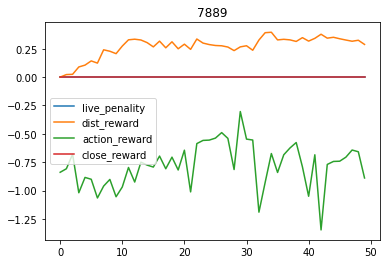

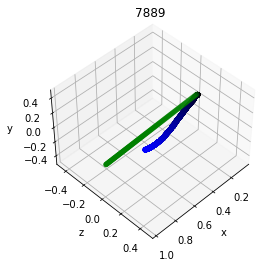

| eval  | E: 167 | S: 7889 | R: -25.3104
| train | E: 168 | S: 7889 | R: -57.9121 | D: 38.3 s | BR: -1.4265 | ALOSS: 12.2836 | CLOSS: 2.2632 | TLOSS: -12.7681 | TVAL: 0.1034 | AENT: -5.0000
| train | E: 169 | S: 7939 | R: -57.6321 | D: 81.0 s | BR: -1.4462 | ALOSS: 12.7038 | CLOSS: 3.1756 | TLOSS: -12.8360 | TVAL: 0.1020 | AENT: -5.0000
| train | E: 170 | S: 7974 | R: -31.3248 | D: 27.8 s | BR: -1.4134 | ALOSS: 12.3976 | CLOSS: 2.6180 | TLOSS: -13.0648 | TVAL: 0.1008 | AENT: -5.0000
| train | E: 171 | S: 8024 | R: -55.6540 | D: 39.2 s | BR: -1.4318 | ALOSS: 12.7236 | CLOSS: 2.3428 | TLOSS: -12.7312 | TVAL: 0.0996 | AENT: -5.0000
| train | E: 172 | S: 8074 | R: -56.3457 | D: 39.0 s | BR: -1.4291 | ALOSS: 12.9900 | CLOSS: 2.3607 | TLOSS: -12.9239 | TVAL: 0.0983 | AENT: -5.0000
| train | E: 173 | S: 8120 | R: -43.8856 | D: 34.9 s | BR: -1.4149 | ALOSS: 12.8223 | CLOSS: 2.8404 | TLOSS: -12.5218 | TVAL: 0.0970 | AENT: -5.0000
| train | E: 174 | S: 8164 | R: -37.2204 | D: 33.5 s | BR: -1.432

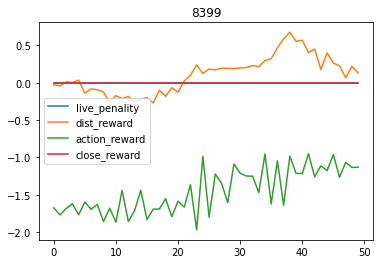

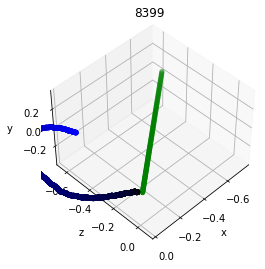

| eval  | E: 178 | S: 8399 | R: -67.0069
| train | E: 179 | S: 8399 | R: -40.9170 | D: 33.5 s | BR: -1.4132 | ALOSS: 13.5956 | CLOSS: 2.9243 | TLOSS: -12.5457 | TVAL: 0.0901 | AENT: -5.0000
| train | E: 180 | S: 8449 | R: -56.1082 | D: 76.1 s | BR: -1.4082 | ALOSS: 13.7445 | CLOSS: 2.5873 | TLOSS: -12.3175 | TVAL: 0.0890 | AENT: -5.0000
| train | E: 181 | S: 8499 | R: -45.9076 | D: 38.0 s | BR: -1.3971 | ALOSS: 13.7893 | CLOSS: 2.8052 | TLOSS: -12.4300 | TVAL: 0.0878 | AENT: -5.0000
| train | E: 182 | S: 8538 | R: -30.0608 | D: 30.8 s | BR: -1.3911 | ALOSS: 13.7654 | CLOSS: 3.5814 | TLOSS: -12.5457 | TVAL: 0.0868 | AENT: -5.0000
| train | E: 183 | S: 8588 | R: -63.6138 | D: 37.8 s | BR: -1.4104 | ALOSS: 13.8781 | CLOSS: 3.6498 | TLOSS: -12.4037 | TVAL: 0.0858 | AENT: -5.0000
| train | E: 184 | S: 8620 | R: -25.1310 | D: 25.5 s | BR: -1.4084 | ALOSS: 14.2105 | CLOSS: 2.3808 | TLOSS: -12.4066 | TVAL: 0.0849 | AENT: -5.0000
| train | E: 185 | S: 8651 | R: -21.8095 | D: 24.0 s | BR: -1.378

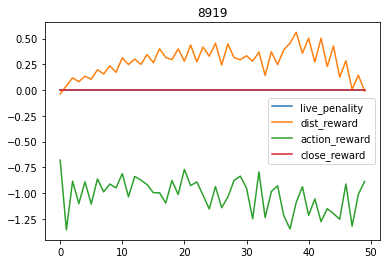

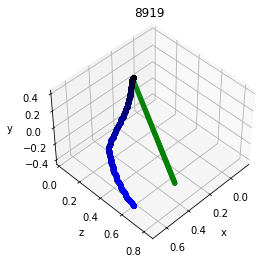

| eval  | E: 190 | S: 8919 | R: -37.0057
| train | E: 191 | S: 8919 | R: -51.3138 | D: 37.9 s | BR: -1.3695 | ALOSS: 14.5097 | CLOSS: 3.0612 | TLOSS: -12.1359 | TVAL: 0.0787 | AENT: -5.0000
| train | E: 192 | S: 8969 | R: -67.2506 | D: 76.0 s | BR: -1.3854 | ALOSS: 14.8417 | CLOSS: 3.0742 | TLOSS: -11.9877 | TVAL: 0.0777 | AENT: -5.0000
| train | E: 193 | S: 9019 | R: -96.7386 | D: 37.8 s | BR: -1.3945 | ALOSS: 14.8804 | CLOSS: 3.9209 | TLOSS: -11.7164 | TVAL: 0.0768 | AENT: -5.0000
| train | E: 194 | S: 9069 | R: -47.0152 | D: 37.9 s | BR: -1.4043 | ALOSS: 14.9304 | CLOSS: 3.8552 | TLOSS: -11.7823 | TVAL: 0.0758 | AENT: -5.0000
| train | E: 195 | S: 9119 | R: -60.3103 | D: 37.9 s | BR: -1.3892 | ALOSS: 15.0661 | CLOSS: 2.6314 | TLOSS: -11.7728 | TVAL: 0.0749 | AENT: -5.0000
| train | E: 196 | S: 9169 | R: -58.3340 | D: 37.7 s | BR: -1.3741 | ALOSS: 15.0923 | CLOSS: 2.8053 | TLOSS: -11.8733 | TVAL: 0.0739 | AENT: -5.0000
| train | E: 197 | S: 9219 | R: -62.7124 | D: 37.8 s | BR: -1.380

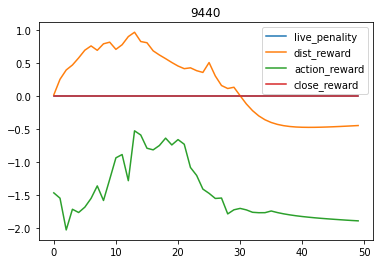

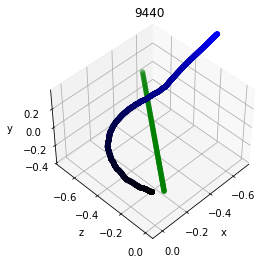

| eval  | E: 201 | S: 9440 | R: -64.8774
| train | E: 202 | S: 9440 | R: -73.9569 | D: 38.4 s | BR: -1.3877 | ALOSS: 15.7165 | CLOSS: 3.4878 | TLOSS: -11.2311 | TVAL: 0.0691 | AENT: -5.0000
| train | E: 203 | S: 9473 | R: -24.6940 | D: 62.5 s | BR: -1.3768 | ALOSS: 15.6894 | CLOSS: 2.9188 | TLOSS: -10.9721 | TVAL: 0.0684 | AENT: -5.0000
| train | E: 204 | S: 9502 | R: -21.2604 | D: 22.6 s | BR: -1.3911 | ALOSS: 15.6759 | CLOSS: 3.6226 | TLOSS: -11.4545 | TVAL: 0.0679 | AENT: -5.0000
| train | E: 205 | S: 9547 | R: -42.1642 | D: 35.1 s | BR: -1.3731 | ALOSS: 16.0720 | CLOSS: 3.1638 | TLOSS: -11.5263 | TVAL: 0.0673 | AENT: -5.0000
| train | E: 206 | S: 9597 | R: -49.4746 | D: 38.1 s | BR: -1.3747 | ALOSS: 15.8571 | CLOSS: 3.2554 | TLOSS: -11.1737 | TVAL: 0.0665 | AENT: -5.0000
| train | E: 207 | S: 9639 | R: -39.1634 | D: 32.0 s | BR: -1.3818 | ALOSS: 16.1614 | CLOSS: 4.1107 | TLOSS: -11.2012 | TVAL: 0.0657 | AENT: -5.0000
| train | E: 208 | S: 9678 | R: -30.9245 | D: 30.2 s | BR: -1.360

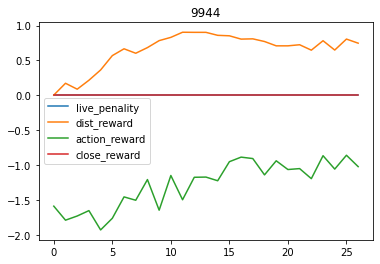

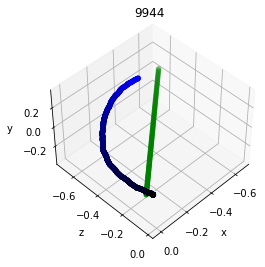

| eval  | E: 213 | S: 9944 | R: -16.8292
| train | E: 214 | S: 9944 | R: -59.4221 | D: 39.3 s | BR: -1.3521 | ALOSS: 16.4185 | CLOSS: 2.8788 | TLOSS: -10.8797 | TVAL: 0.0610 | AENT: -5.0000
| train | E: 215 | S: 9983 | R: -34.3266 | D: 50.2 s | BR: -1.3926 | ALOSS: 16.6874 | CLOSS: 3.9829 | TLOSS: -10.9762 | TVAL: 0.0603 | AENT: -5.0000
| train | E: 216 | S: 10016 | R: -26.6885 | D: 25.5 s | BR: -1.3605 | ALOSS: 16.7551 | CLOSS: 3.3651 | TLOSS: -10.8629 | TVAL: 0.0598 | AENT: -5.0000
| train | E: 217 | S: 10046 | R: -17.9676 | D: 22.9 s | BR: -1.3480 | ALOSS: 16.4918 | CLOSS: 4.2598 | TLOSS: -10.7693 | TVAL: 0.0593 | AENT: -5.0000
| train | E: 218 | S: 10080 | R: -26.1853 | D: 26.3 s | BR: -1.3596 | ALOSS: 16.7849 | CLOSS: 2.2779 | TLOSS: -10.8171 | TVAL: 0.0589 | AENT: -5.0000
| train | E: 219 | S: 10130 | R: -63.9500 | D: 37.9 s | BR: -1.3473 | ALOSS: 16.7506 | CLOSS: 4.0423 | TLOSS: -11.0876 | TVAL: 0.0583 | AENT: -5.0000
| train | E: 220 | S: 10155 | R: -16.8163 | D: 19.8 s | BR: -

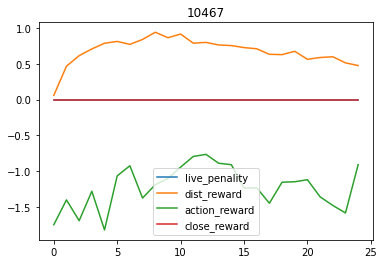

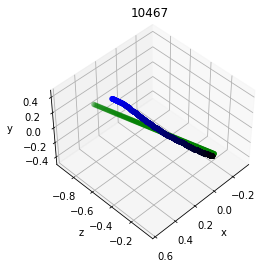

| eval  | E: 227 | S: 10467 | R: -13.6059
| train | E: 228 | S: 10467 | R: -21.9333 | D: 26.3 s | BR: -1.3484 | ALOSS: 17.3536 | CLOSS: 4.0686 | TLOSS: -10.5479 | TVAL: 0.0535 | AENT: -5.0000
| train | E: 229 | S: 10502 | R: -28.7558 | D: 47.5 s | BR: -1.3283 | ALOSS: 17.1619 | CLOSS: 4.2570 | TLOSS: -10.9242 | TVAL: 0.0531 | AENT: -5.0000
| train | E: 230 | S: 10550 | R: -48.0492 | D: 37.1 s | BR: -1.3193 | ALOSS: 17.2098 | CLOSS: 3.1839 | TLOSS: -10.8180 | TVAL: 0.0525 | AENT: -5.0000
| train | E: 231 | S: 10591 | R: -39.0164 | D: 32.6 s | BR: -1.3327 | ALOSS: 17.2442 | CLOSS: 3.4710 | TLOSS: -10.2034 | TVAL: 0.0519 | AENT: -5.0000
| train | E: 232 | S: 10641 | R: -58.4814 | D: 39.3 s | BR: -1.3638 | ALOSS: 17.5454 | CLOSS: 4.7263 | TLOSS: -9.9720 | TVAL: 0.0514 | AENT: -5.0000
| train | E: 233 | S: 10691 | R: -62.2082 | D: 38.3 s | BR: -1.3366 | ALOSS: 17.4005 | CLOSS: 3.7985 | TLOSS: -10.4565 | TVAL: 0.0507 | AENT: -5.0000
| train | E: 234 | S: 10718 | R: -14.8850 | D: 20.8 s | BR:

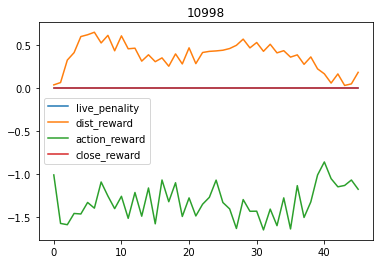

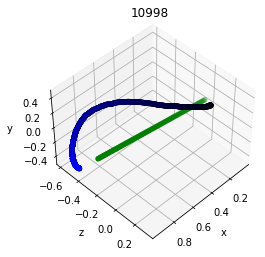

| eval  | E: 240 | S: 10998 | R: -43.6165
| train | E: 241 | S: 10998 | R: -28.7979 | D: 27.2 s | BR: -1.3002 | ALOSS: 17.7080 | CLOSS: 3.9990 | TLOSS: -9.1221 | TVAL: 0.0471 | AENT: -5.0000
| train | E: 242 | S: 11048 | R: -51.3000 | D: 73.0 s | BR: -1.3110 | ALOSS: 17.5738 | CLOSS: 4.5999 | TLOSS: -9.3317 | TVAL: 0.0467 | AENT: -5.0000
| train | E: 243 | S: 11098 | R: -60.4422 | D: 38.1 s | BR: -1.3148 | ALOSS: 17.6556 | CLOSS: 3.5827 | TLOSS: -8.4878 | TVAL: 0.0461 | AENT: -5.0000
| train | E: 244 | S: 11137 | R: -37.0167 | D: 31.2 s | BR: -1.3240 | ALOSS: 17.8231 | CLOSS: 3.7011 | TLOSS: -9.2007 | TVAL: 0.0457 | AENT: -5.0000
| train | E: 245 | S: 11170 | R: -29.6606 | D: 26.2 s | BR: -1.3301 | ALOSS: 17.8877 | CLOSS: 3.3686 | TLOSS: -9.1053 | TVAL: 0.0453 | AENT: -5.0000
| train | E: 246 | S: 11203 | R: -25.0811 | D: 26.4 s | BR: -1.3080 | ALOSS: 17.6861 | CLOSS: 4.3913 | TLOSS: -8.8354 | TVAL: 0.0450 | AENT: -5.0000
| train | E: 247 | S: 11253 | R: -45.8395 | D: 38.7 s | BR: -1.3

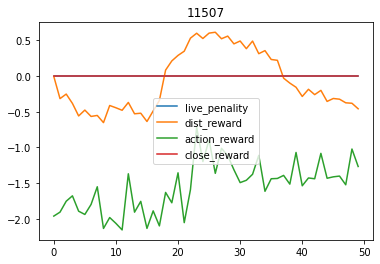

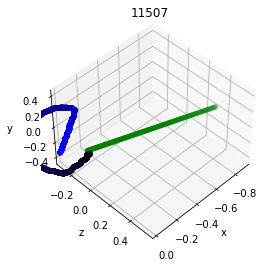

| eval  | E: 252 | S: 11507 | R: -80.9760
| train | E: 253 | S: 11507 | R: -53.4758 | D: 38.3 s | BR: -1.3156 | ALOSS: 18.1670 | CLOSS: 3.7578 | TLOSS: -8.5505 | TVAL: 0.0422 | AENT: -5.0000
| train | E: 254 | S: 11536 | R: -23.5502 | D: 62.4 s | BR: -1.2981 | ALOSS: 17.7768 | CLOSS: 3.5899 | TLOSS: -7.8591 | TVAL: 0.0418 | AENT: -5.0000
| train | E: 255 | S: 11579 | R: -39.8691 | D: 32.4 s | BR: -1.2893 | ALOSS: 17.9523 | CLOSS: 3.2651 | TLOSS: -7.9804 | TVAL: 0.0415 | AENT: -5.0000
| train | E: 256 | S: 11629 | R: -64.6559 | D: 38.5 s | BR: -1.3203 | ALOSS: 18.2910 | CLOSS: 3.9453 | TLOSS: -7.8291 | TVAL: 0.0411 | AENT: -5.0000
| train | E: 257 | S: 11653 | R: -33.4000 | D: 19.0 s | BR: -1.3394 | ALOSS: 18.0809 | CLOSS: 4.7495 | TLOSS: -7.3151 | TVAL: 0.0407 | AENT: -5.0000
| train | E: 258 | S: 11674 | R: -15.4573 | D: 17.7 s | BR: -1.3335 | ALOSS: 18.0712 | CLOSS: 4.4795 | TLOSS: -7.9305 | TVAL: 0.0405 | AENT: -5.0000
| train | E: 259 | S: 11724 | R: -77.4048 | D: 38.8 s | BR: -1.3

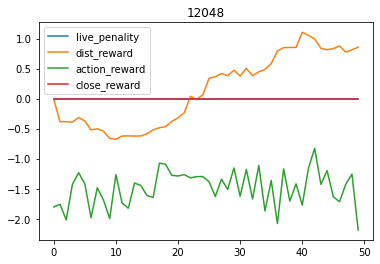

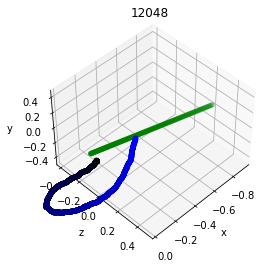

| eval  | E: 267 | S: 12048 | R: -67.6573
| train | E: 268 | S: 12048 | R: -49.4061 | D: 38.2 s | BR: -1.3059 | ALOSS: 18.3679 | CLOSS: 4.5266 | TLOSS: -7.7793 | TVAL: 0.0375 | AENT: -5.0000
| train | E: 269 | S: 12085 | R: -39.2551 | D: 69.0 s | BR: -1.2975 | ALOSS: 18.2717 | CLOSS: 4.1925 | TLOSS: -7.5072 | TVAL: 0.0371 | AENT: -5.0000
| train | E: 270 | S: 12113 | R: -18.6774 | D: 21.8 s | BR: -1.3184 | ALOSS: 18.4679 | CLOSS: 4.8014 | TLOSS: -5.8375 | TVAL: 0.0369 | AENT: -5.0000
| train | E: 271 | S: 12163 | R: -67.8907 | D: 38.6 s | BR: -1.2907 | ALOSS: 18.1692 | CLOSS: 4.6234 | TLOSS: -7.3583 | TVAL: 0.0366 | AENT: -5.0000
| train | E: 272 | S: 12209 | R: -52.0831 | D: 35.0 s | BR: -1.3259 | ALOSS: 18.6980 | CLOSS: 3.7499 | TLOSS: -6.6299 | TVAL: 0.0362 | AENT: -5.0000
| train | E: 273 | S: 12228 | R: -12.0364 | D: 15.5 s | BR: -1.2700 | ALOSS: 18.1546 | CLOSS: 3.5638 | TLOSS: -7.0118 | TVAL: 0.0360 | AENT: -5.0000
| train | E: 274 | S: 12278 | R: -63.0400 | D: 39.9 s | BR: -1.2

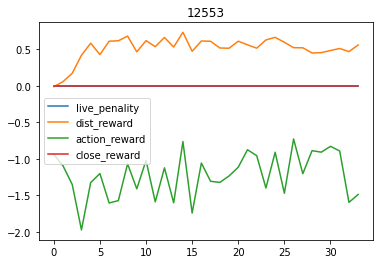

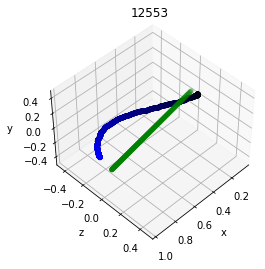

| eval  | E: 281 | S: 12553 | R: -24.2493
| train | E: 282 | S: 12553 | R: -67.0118 | D: 38.0 s | BR: -1.2902 | ALOSS: 18.6670 | CLOSS: 4.4463 | TLOSS: -5.8563 | TVAL: 0.0338 | AENT: -5.0000
| train | E: 283 | S: 12577 | R: -17.2586 | D: 46.0 s | BR: -1.2795 | ALOSS: 18.3578 | CLOSS: 4.9361 | TLOSS: -6.0483 | TVAL: 0.0335 | AENT: -5.0000
| train | E: 284 | S: 12605 | R: -21.0619 | D: 21.9 s | BR: -1.2726 | ALOSS: 18.4314 | CLOSS: 3.7901 | TLOSS: -6.2074 | TVAL: 0.0333 | AENT: -5.0000
| train | E: 285 | S: 12623 | R: -11.8619 | D: 14.8 s | BR: -1.2808 | ALOSS: 18.4162 | CLOSS: 3.1631 | TLOSS: -6.5663 | TVAL: 0.0332 | AENT: -5.0000
| train | E: 286 | S: 12672 | R: -46.7893 | D: 36.7 s | BR: -1.3091 | ALOSS: 18.7182 | CLOSS: 4.5414 | TLOSS: -5.8048 | TVAL: 0.0330 | AENT: -5.0000
| train | E: 287 | S: 12698 | R: -14.9896 | D: 21.7 s | BR: -1.2858 | ALOSS: 18.7549 | CLOSS: 4.2049 | TLOSS: -6.4285 | TVAL: 0.0327 | AENT: -5.0000
| train | E: 288 | S: 12720 | R: -28.2782 | D: 18.2 s | BR: -1.2

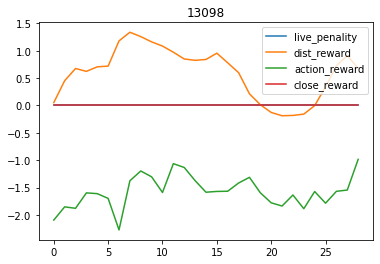

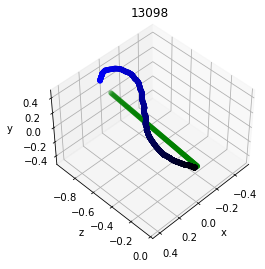

| eval  | E: 297 | S: 13098 | R: -28.3710
| train | E: 298 | S: 13098 | R: -61.3428 | D: 40.3 s | BR: -1.2871 | ALOSS: 18.7646 | CLOSS: 4.3122 | TLOSS: -4.4335 | TVAL: 0.0303 | AENT: -5.0000
| train | E: 299 | S: 13121 | R: -18.3611 | D: 41.6 s | BR: -1.3085 | ALOSS: 18.9625 | CLOSS: 4.8645 | TLOSS: -5.7814 | TVAL: 0.0301 | AENT: -5.0000
| train | E: 300 | S: 13141 | R: -9.9115 | D: 16.1 s | BR: -1.2764 | ALOSS: 18.4873 | CLOSS: 5.6297 | TLOSS: -4.6260 | TVAL: 0.0299 | AENT: -5.0000
| train | E: 301 | S: 13168 | R: -20.8972 | D: 21.4 s | BR: -1.2655 | ALOSS: 18.8337 | CLOSS: 3.5063 | TLOSS: -4.8929 | TVAL: 0.0298 | AENT: -5.0000
| train | E: 302 | S: 13207 | R: -40.7616 | D: 31.0 s | BR: -1.2916 | ALOSS: 18.9226 | CLOSS: 4.0002 | TLOSS: -5.8180 | TVAL: 0.0296 | AENT: -5.0000
| train | E: 303 | S: 13257 | R: -56.4831 | D: 37.9 s | BR: -1.2723 | ALOSS: 18.7818 | CLOSS: 3.8984 | TLOSS: -5.4618 | TVAL: 0.0294 | AENT: -5.0000
| train | E: 304 | S: 13289 | R: -34.0993 | D: 25.0 s | BR: -1.28

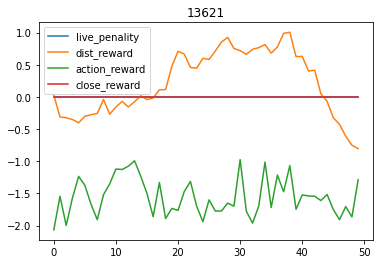

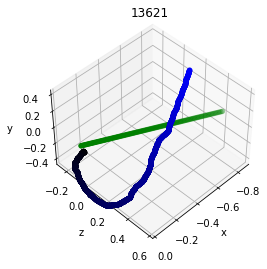

| eval  | E: 314 | S: 13621 | R: -66.9850
| train | E: 315 | S: 13621 | R: -18.9740 | D: 22.4 s | BR: -1.2598 | ALOSS: 18.6571 | CLOSS: 4.5362 | TLOSS: -4.6669 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 316 | S: 13657 | R: -33.2054 | D: 66.6 s | BR: -1.2886 | ALOSS: 19.0271 | CLOSS: 4.6561 | TLOSS: -3.8837 | TVAL: 0.0272 | AENT: -5.0000
| train | E: 317 | S: 13679 | R: -14.0301 | D: 20.5 s | BR: -1.2582 | ALOSS: 18.1003 | CLOSS: 5.4432 | TLOSS: -4.7218 | TVAL: 0.0270 | AENT: -5.0000
| train | E: 318 | S: 13706 | R: -22.9211 | D: 20.9 s | BR: -1.2795 | ALOSS: 19.0382 | CLOSS: 3.5103 | TLOSS: -4.9133 | TVAL: 0.0269 | AENT: -5.0000
| train | E: 319 | S: 13729 | R: -14.3576 | D: 19.1 s | BR: -1.2512 | ALOSS: 18.6742 | CLOSS: 5.5536 | TLOSS: -4.8919 | TVAL: 0.0268 | AENT: -5.0000
| train | E: 320 | S: 13759 | R: -24.4899 | D: 24.2 s | BR: -1.2654 | ALOSS: 18.9123 | CLOSS: 4.6729 | TLOSS: -3.9286 | TVAL: 0.0266 | AENT: -5.0000
| train | E: 321 | S: 13797 | R: -36.2058 | D: 30.7 s | BR: -1.2

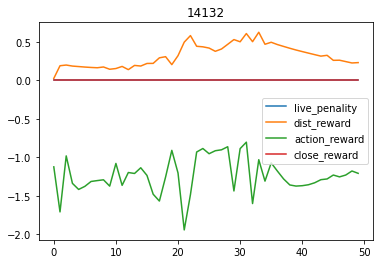

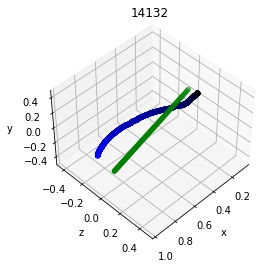

| eval  | E: 331 | S: 14132 | R: -45.6622
| train | E: 332 | S: 14132 | R: -12.2030 | D: 19.7 s | BR: -1.2489 | ALOSS: 18.5899 | CLOSS: 3.8578 | TLOSS: -3.4460 | TVAL: 0.0250 | AENT: -5.0000
| train | E: 333 | S: 14182 | R: -54.4873 | D: 77.2 s | BR: -1.2764 | ALOSS: 19.1130 | CLOSS: 4.3587 | TLOSS: -4.0319 | TVAL: 0.0248 | AENT: -5.0000
| train | E: 334 | S: 14215 | R: -27.0621 | D: 25.9 s | BR: -1.2699 | ALOSS: 19.1175 | CLOSS: 3.8847 | TLOSS: -3.3274 | TVAL: 0.0247 | AENT: -5.0000
| train | E: 335 | S: 14239 | R: -14.8417 | D: 19.4 s | BR: -1.2632 | ALOSS: 19.1603 | CLOSS: 4.0800 | TLOSS: -4.1429 | TVAL: 0.0245 | AENT: -5.0000
| train | E: 336 | S: 14271 | R: -26.3007 | D: 25.1 s | BR: -1.2579 | ALOSS: 18.8616 | CLOSS: 5.1646 | TLOSS: -2.9342 | TVAL: 0.0244 | AENT: -5.0000
| train | E: 337 | S: 14305 | R: -28.1999 | D: 25.9 s | BR: -1.2534 | ALOSS: 18.9948 | CLOSS: 4.9916 | TLOSS: -3.1191 | TVAL: 0.0243 | AENT: -5.0000
| train | E: 338 | S: 14341 | R: -32.9681 | D: 27.6 s | BR: -1.2

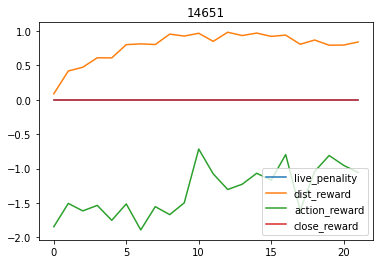

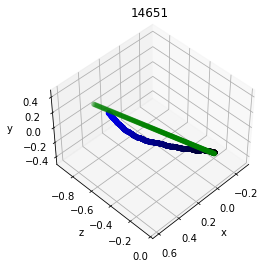

| eval  | E: 346 | S: 14651 | R: -12.0524
| train | E: 347 | S: 14651 | R: -32.2923 | D: 26.5 s | BR: -1.2149 | ALOSS: 18.6038 | CLOSS: 3.7953 | TLOSS: -3.1877 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 348 | S: 14678 | R: -20.9519 | D: 38.6 s | BR: -1.2282 | ALOSS: 18.5386 | CLOSS: 3.7625 | TLOSS: -2.0929 | TVAL: 0.0230 | AENT: -5.0000
| train | E: 349 | S: 14727 | R: -54.6905 | D: 38.0 s | BR: -1.2542 | ALOSS: 18.6391 | CLOSS: 4.4630 | TLOSS: -2.5697 | TVAL: 0.0229 | AENT: -5.0000
| train | E: 350 | S: 14766 | R: -39.5653 | D: 30.3 s | BR: -1.2419 | ALOSS: 18.7143 | CLOSS: 4.4058 | TLOSS: -2.1205 | TVAL: 0.0227 | AENT: -5.0000
| train | E: 351 | S: 14796 | R: -25.0809 | D: 23.8 s | BR: -1.2368 | ALOSS: 18.7599 | CLOSS: 4.2012 | TLOSS: -3.3906 | TVAL: 0.0226 | AENT: -5.0000
| train | E: 352 | S: 14829 | R: -30.4757 | D: 25.3 s | BR: -1.2294 | ALOSS: 18.7603 | CLOSS: 4.4201 | TLOSS: -2.4083 | TVAL: 0.0225 | AENT: -5.0000
| train | E: 353 | S: 14864 | R: -33.6555 | D: 28.4 s | BR: -1.2

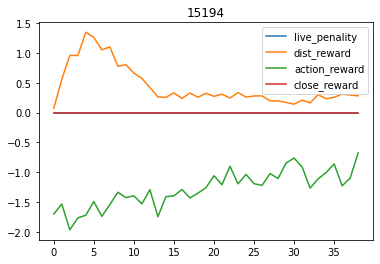

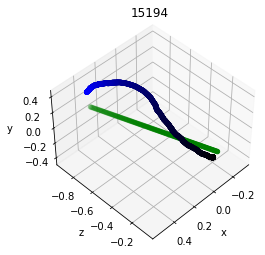

| eval  | E: 361 | S: 15194 | R: -32.7973
| train | E: 362 | S: 15194 | R: -47.5695 | D: 38.7 s | BR: -1.2202 | ALOSS: 18.5585 | CLOSS: 4.6630 | TLOSS: -2.5041 | TVAL: 0.0215 | AENT: -5.0000
| train | E: 363 | S: 15225 | R: -30.8744 | D: 55.2 s | BR: -1.2334 | ALOSS: 18.6628 | CLOSS: 4.9112 | TLOSS: -1.7052 | TVAL: 0.0213 | AENT: -5.0000
| train | E: 364 | S: 15251 | R: -19.8806 | D: 20.4 s | BR: -1.2359 | ALOSS: 18.6468 | CLOSS: 4.4963 | TLOSS: -0.2910 | TVAL: 0.0213 | AENT: -5.0000
| train | E: 365 | S: 15284 | R: -27.4406 | D: 25.6 s | BR: -1.2229 | ALOSS: 18.5522 | CLOSS: 3.4688 | TLOSS: -1.5027 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 366 | S: 15310 | R: -16.9339 | D: 20.7 s | BR: -1.2196 | ALOSS: 18.3310 | CLOSS: 5.0198 | TLOSS: -2.6696 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 367 | S: 15338 | R: -21.5693 | D: 21.8 s | BR: -1.2152 | ALOSS: 18.2731 | CLOSS: 4.1378 | TLOSS: -1.2675 | TVAL: 0.0211 | AENT: -5.0000
| train | E: 368 | S: 15374 | R: -31.8701 | D: 29.1 s | BR: -1.2

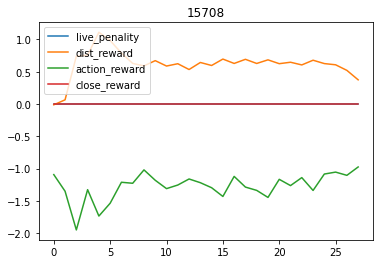

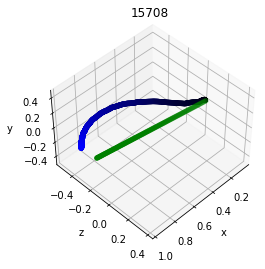

| eval  | E: 376 | S: 15708 | R: -18.3182
| train | E: 377 | S: 15708 | R: -66.3937 | D: 39.0 s | BR: -1.2168 | ALOSS: 18.4810 | CLOSS: 5.2886 | TLOSS: -0.0799 | TVAL: 0.0203 | AENT: -5.0000
| train | E: 378 | S: 15736 | R: -49.1265 | D: 43.3 s | BR: -1.2068 | ALOSS: 18.2173 | CLOSS: 5.3231 | TLOSS: -0.6632 | TVAL: 0.0203 | AENT: -5.0000
| train | E: 379 | S: 15786 | R: -96.7967 | D: 38.3 s | BR: -1.2276 | ALOSS: 18.5025 | CLOSS: 4.3889 | TLOSS: -1.1806 | TVAL: 0.0202 | AENT: -5.0000
| train | E: 380 | S: 15836 | R: -63.6166 | D: 38.5 s | BR: -1.2225 | ALOSS: 18.5169 | CLOSS: 3.7692 | TLOSS: -0.3304 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 381 | S: 15859 | R: -16.0615 | D: 19.6 s | BR: -1.2193 | ALOSS: 18.5998 | CLOSS: 4.2291 | TLOSS: -1.4763 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 382 | S: 15889 | R: -21.4722 | D: 23.8 s | BR: -1.2163 | ALOSS: 18.5274 | CLOSS: 3.6420 | TLOSS: -0.4372 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 383 | S: 15916 | R: -18.5491 | D: 21.2 s | BR: -1.2

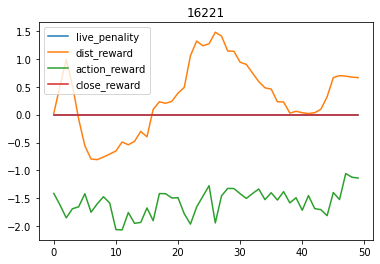

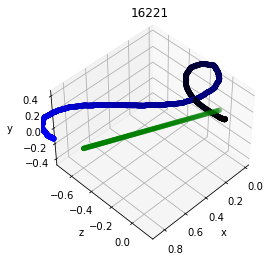

| eval  | E: 394 | S: 16221 | R: -62.8498
| train | E: 395 | S: 16221 | R: -35.1884 | D: 19.8 s | BR: -1.2284 | ALOSS: 18.5355 | CLOSS: 3.6995 | TLOSS: -1.0034 | TVAL: 0.0198 | AENT: -5.0000
| train | E: 396 | S: 16255 | R: -33.7552 | D: 66.3 s | BR: -1.2067 | ALOSS: 18.3997 | CLOSS: 4.0294 | TLOSS: -0.6145 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 397 | S: 16297 | R: -61.3145 | D: 33.2 s | BR: -1.2191 | ALOSS: 18.6530 | CLOSS: 3.8774 | TLOSS: 0.0509 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 398 | S: 16316 | R: -12.2050 | D: 15.5 s | BR: -1.2199 | ALOSS: 18.2129 | CLOSS: 5.0357 | TLOSS: -0.8565 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 399 | S: 16366 | R: -53.4816 | D: 40.3 s | BR: -1.2310 | ALOSS: 18.3907 | CLOSS: 4.7106 | TLOSS: 0.0111 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 400 | S: 16384 | R: -9.2649 | D: 14.6 s | BR: -1.2313 | ALOSS: 18.6312 | CLOSS: 3.7276 | TLOSS: 0.2963 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 401 | S: 16407 | R: -13.7680 | D: 18.9 s | BR: -1.1914 

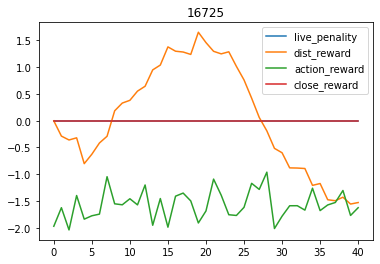

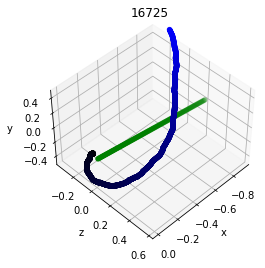

| eval  | E: 410 | S: 16725 | R: -62.9000
| train | E: 411 | S: 16725 | R: -41.3444 | D: 34.2 s | BR: -1.2246 | ALOSS: 18.2822 | CLOSS: 4.2928 | TLOSS: -0.5578 | TVAL: 0.0196 | AENT: -5.0000
| train | E: 412 | S: 16747 | R: -14.5102 | D: 49.4 s | BR: -1.2111 | ALOSS: 18.0166 | CLOSS: 4.2501 | TLOSS: 0.4945 | TVAL: 0.0196 | AENT: -5.0000
| train | E: 413 | S: 16769 | R: -31.4409 | D: 17.4 s | BR: -1.2079 | ALOSS: 18.0067 | CLOSS: 3.5392 | TLOSS: -0.4226 | TVAL: 0.0196 | AENT: -5.0000
| train | E: 414 | S: 16785 | R: -7.9428 | D: 14.2 s | BR: -1.1945 | ALOSS: 17.7246 | CLOSS: 3.9862 | TLOSS: 1.2633 | TVAL: 0.0196 | AENT: -5.0000
| train | E: 415 | S: 16811 | R: -17.0410 | D: 20.2 s | BR: -1.2240 | ALOSS: 18.2503 | CLOSS: 3.7253 | TLOSS: 2.2268 | TVAL: 0.0197 | AENT: -5.0000
| train | E: 416 | S: 16833 | R: -17.2452 | D: 18.1 s | BR: -1.2019 | ALOSS: 17.6097 | CLOSS: 4.2326 | TLOSS: 0.3877 | TVAL: 0.0198 | AENT: -5.0000
| train | E: 417 | S: 16857 | R: -16.0877 | D: 18.7 s | BR: -1.1799 |

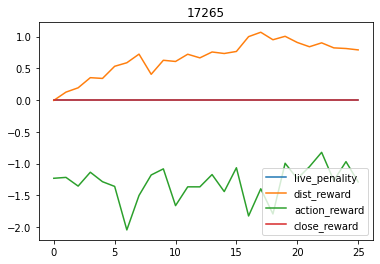

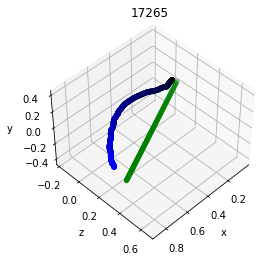

| eval  | E: 428 | S: 17265 | R: -16.8844
| train | E: 429 | S: 17265 | R: -66.0863 | D: 38.4 s | BR: -1.2022 | ALOSS: 17.8698 | CLOSS: 4.4155 | TLOSS: 0.1615 | TVAL: 0.0200 | AENT: -5.0000
| train | E: 430 | S: 17290 | R: -17.9690 | D: 41.2 s | BR: -1.2326 | ALOSS: 18.1008 | CLOSS: 3.6039 | TLOSS: 0.1110 | TVAL: 0.0200 | AENT: -5.0000
| train | E: 431 | S: 17340 | R: -59.9087 | D: 40.0 s | BR: -1.1993 | ALOSS: 17.8509 | CLOSS: 4.9050 | TLOSS: 0.6857 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 432 | S: 17390 | R: -48.8235 | D: 38.9 s | BR: -1.2001 | ALOSS: 17.8522 | CLOSS: 4.0410 | TLOSS: -0.4637 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 433 | S: 17416 | R: -16.7979 | D: 21.4 s | BR: -1.2001 | ALOSS: 17.7536 | CLOSS: 5.1387 | TLOSS: 0.4505 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 434 | S: 17445 | R: -21.0645 | D: 22.6 s | BR: -1.2044 | ALOSS: 17.7022 | CLOSS: 4.2786 | TLOSS: -0.0425 | TVAL: 0.0201 | AENT: -5.0000
| train | E: 435 | S: 17469 | R: -11.9814 | D: 19.0 s | BR: -1.2043 

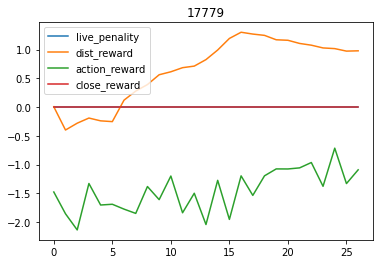

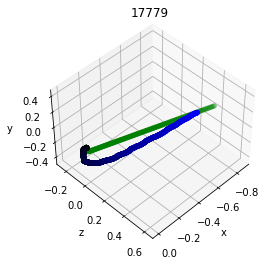

| eval  | E: 446 | S: 17779 | R: -21.8455
| train | E: 447 | S: 17779 | R: -9.2143 | D: 16.2 s | BR: -1.2185 | ALOSS: 17.9719 | CLOSS: 3.3205 | TLOSS: 1.0858 | TVAL: 0.0205 | AENT: -5.0000
| train | E: 448 | S: 17799 | R: -11.9840 | D: 37.6 s | BR: -1.1939 | ALOSS: 17.5600 | CLOSS: 4.0383 | TLOSS: 0.3382 | TVAL: 0.0206 | AENT: -5.0000
| train | E: 449 | S: 17831 | R: -27.2266 | D: 24.6 s | BR: -1.1893 | ALOSS: 17.4028 | CLOSS: 3.9930 | TLOSS: -0.2868 | TVAL: 0.0206 | AENT: -5.0000
| train | E: 450 | S: 17876 | R: -43.7039 | D: 34.6 s | BR: -1.1739 | ALOSS: 17.3482 | CLOSS: 4.5818 | TLOSS: 0.5352 | TVAL: 0.0206 | AENT: -5.0000
| train | E: 451 | S: 17907 | R: -21.9240 | D: 24.4 s | BR: -1.1945 | ALOSS: 17.7239 | CLOSS: 4.0372 | TLOSS: -0.0825 | TVAL: 0.0206 | AENT: -5.0000
| train | E: 452 | S: 17929 | R: -11.3690 | D: 17.9 s | BR: -1.1729 | ALOSS: 17.5783 | CLOSS: 5.8108 | TLOSS: 0.4442 | TVAL: 0.0206 | AENT: -5.0000
| train | E: 453 | S: 17979 | R: -58.3440 | D: 38.6 s | BR: -1.2055 |

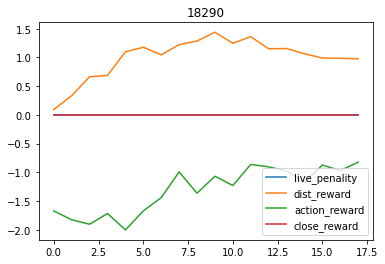

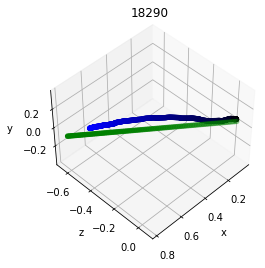

| eval  | E: 464 | S: 18290 | R: -5.5356
| train | E: 465 | S: 18290 | R: -12.8211 | D: 17.3 s | BR: -1.1768 | ALOSS: 17.5590 | CLOSS: 4.2982 | TLOSS: 0.0316 | TVAL: 0.0211 | AENT: -5.0000
| train | E: 466 | S: 18340 | R: -59.8544 | D: 52.7 s | BR: -1.1810 | ALOSS: 17.4503 | CLOSS: 3.6644 | TLOSS: -0.0235 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 467 | S: 18386 | R: -49.8363 | D: 36.2 s | BR: -1.1851 | ALOSS: 17.2728 | CLOSS: 4.3209 | TLOSS: 0.1861 | TVAL: 0.0211 | AENT: -5.0000
| train | E: 468 | S: 18425 | R: -37.3529 | D: 30.5 s | BR: -1.1607 | ALOSS: 17.1803 | CLOSS: 3.4405 | TLOSS: 0.3054 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 469 | S: 18452 | R: -18.8295 | D: 20.7 s | BR: -1.1982 | ALOSS: 16.9608 | CLOSS: 6.0543 | TLOSS: -0.4492 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 470 | S: 18498 | R: -40.1319 | D: 36.0 s | BR: -1.1893 | ALOSS: 17.6429 | CLOSS: 3.7278 | TLOSS: -0.0265 | TVAL: 0.0212 | AENT: -5.0000
| train | E: 471 | S: 18527 | R: -23.0020 | D: 23.0 s | BR: -1.1900 

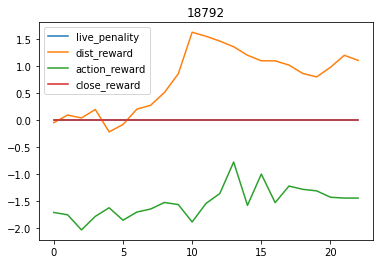

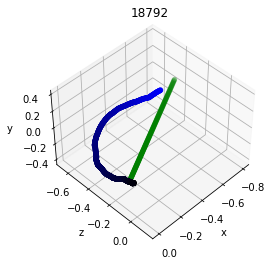

| eval  | E: 480 | S: 18792 | R: -17.8364
| train | E: 481 | S: 18792 | R: -25.3003 | D: 24.8 s | BR: -1.1818 | ALOSS: 17.2238 | CLOSS: 4.7263 | TLOSS: 1.5544 | TVAL: 0.0217 | AENT: -5.0000
| train | E: 482 | S: 18819 | R: -22.8885 | D: 39.9 s | BR: -1.1695 | ALOSS: 17.0549 | CLOSS: 3.9562 | TLOSS: 0.8961 | TVAL: 0.0219 | AENT: -5.0000
| train | E: 483 | S: 18837 | R: -8.8879 | D: 15.6 s | BR: -1.1553 | ALOSS: 17.3412 | CLOSS: 4.0937 | TLOSS: 0.7857 | TVAL: 0.0220 | AENT: -5.0000
| train | E: 484 | S: 18870 | R: -22.9416 | D: 26.7 s | BR: -1.1589 | ALOSS: 17.0614 | CLOSS: 4.3250 | TLOSS: 0.2927 | TVAL: 0.0220 | AENT: -5.0000
| train | E: 485 | S: 18889 | R: -7.6034 | D: 15.4 s | BR: -1.2030 | ALOSS: 17.3862 | CLOSS: 2.6519 | TLOSS: 0.6859 | TVAL: 0.0221 | AENT: -5.0000
| train | E: 486 | S: 18927 | R: -35.0453 | D: 29.8 s | BR: -1.1705 | ALOSS: 16.9967 | CLOSS: 4.8313 | TLOSS: 1.6046 | TVAL: 0.0222 | AENT: -5.0000
| train | E: 487 | S: 18966 | R: -36.5684 | D: 30.5 s | BR: -1.1638 | AL

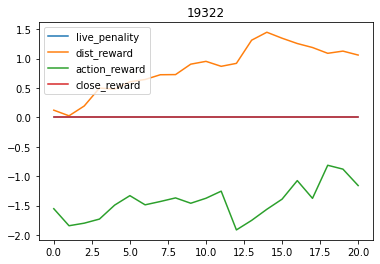

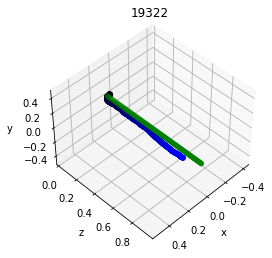

| eval  | E: 499 | S: 19322 | R: -12.5209
| train | E: 500 | S: 19322 | R: -49.3757 | D: 39.9 s | BR: -1.1695 | ALOSS: 16.4453 | CLOSS: 3.8988 | TLOSS: -0.3691 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 501 | S: 19348 | R: -19.7228 | D: 38.0 s | BR: -1.1808 | ALOSS: 16.9537 | CLOSS: 4.3698 | TLOSS: 0.8847 | TVAL: 0.0230 | AENT: -5.0000
| train | E: 502 | S: 19387 | R: -36.2201 | D: 29.8 s | BR: -1.1774 | ALOSS: 16.9626 | CLOSS: 4.3454 | TLOSS: 0.2637 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 503 | S: 19409 | R: -14.4567 | D: 17.6 s | BR: -1.1700 | ALOSS: 16.3758 | CLOSS: 4.3676 | TLOSS: 0.2224 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 504 | S: 19430 | R: -11.1470 | D: 17.1 s | BR: -1.1563 | ALOSS: 16.3964 | CLOSS: 3.8186 | TLOSS: 0.7411 | TVAL: 0.0232 | AENT: -5.0000
| train | E: 505 | S: 19449 | R: -10.1507 | D: 15.6 s | BR: -1.1724 | ALOSS: 17.0021 | CLOSS: 4.5768 | TLOSS: -0.1480 | TVAL: 0.0232 | AENT: -5.0000
| train | E: 506 | S: 19473 | R: -14.8911 | D: 18.8 s | BR: -1.1614 

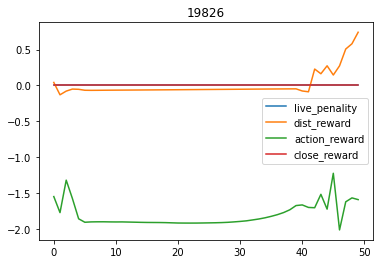

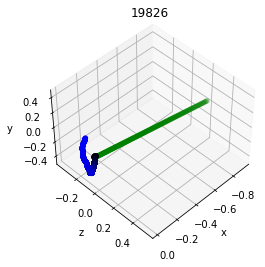

| eval  | E: 519 | S: 19826 | R: -89.8867
| train | E: 520 | S: 19826 | R: -9.9022 | D: 16.5 s | BR: -1.1526 | ALOSS: 16.8853 | CLOSS: 4.6330 | TLOSS: 0.6893 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 521 | S: 19847 | R: -9.3561 | D: 54.4 s | BR: -1.1727 | ALOSS: 16.6207 | CLOSS: 4.7937 | TLOSS: 0.0344 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 522 | S: 19877 | R: -26.8432 | D: 23.3 s | BR: -1.1496 | ALOSS: 16.6177 | CLOSS: 4.2006 | TLOSS: 0.7759 | TVAL: 0.0232 | AENT: -5.0000
| train | E: 523 | S: 19910 | R: -29.7720 | D: 24.9 s | BR: -1.1324 | ALOSS: 16.4082 | CLOSS: 3.9991 | TLOSS: -0.6716 | TVAL: 0.0232 | AENT: -5.0000
| train | E: 524 | S: 19932 | R: -14.4524 | D: 17.4 s | BR: -1.1629 | ALOSS: 16.5502 | CLOSS: 3.0024 | TLOSS: -0.3049 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 525 | S: 19967 | R: -28.5141 | D: 26.7 s | BR: -1.1796 | ALOSS: 16.4229 | CLOSS: 4.7132 | TLOSS: 1.3254 | TVAL: 0.0231 | AENT: -5.0000
| train | E: 526 | S: 19992 | R: -19.1590 | D: 19.5 s | BR: -1.1427 | 

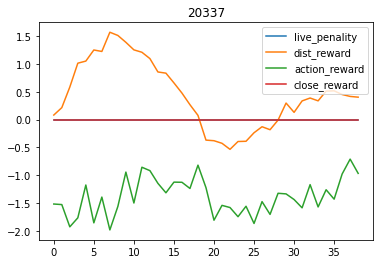

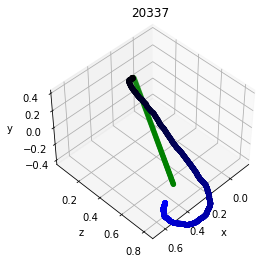

| eval  | E: 541 | S: 20337 | R: -36.5983
| train | E: 542 | S: 20337 | R: -23.0652 | D: 21.4 s | BR: -1.1303 | ALOSS: 15.8850 | CLOSS: 4.0421 | TLOSS: 0.4444 | TVAL: 0.0241 | AENT: -5.0000
| train | E: 543 | S: 20354 | R: -25.7760 | D: 44.4 s | BR: -1.1623 | ALOSS: 16.0544 | CLOSS: 4.6028 | TLOSS: 0.3667 | TVAL: 0.0241 | AENT: -5.0000
| train | E: 544 | S: 20371 | R: -7.9605 | D: 14.1 s | BR: -1.1297 | ALOSS: 16.1446 | CLOSS: 4.6694 | TLOSS: 0.7836 | TVAL: 0.0242 | AENT: -5.0000
| train | E: 545 | S: 20389 | R: -7.6755 | D: 14.7 s | BR: -1.1585 | ALOSS: 16.2486 | CLOSS: 3.8619 | TLOSS: 1.3314 | TVAL: 0.0243 | AENT: -5.0000
| train | E: 546 | S: 20414 | R: -17.0197 | D: 20.6 s | BR: -1.1520 | ALOSS: 15.5482 | CLOSS: 4.0651 | TLOSS: 0.3260 | TVAL: 0.0244 | AENT: -5.0000
| train | E: 547 | S: 20437 | R: -17.1122 | D: 18.0 s | BR: -1.1787 | ALOSS: 16.1471 | CLOSS: 3.6360 | TLOSS: 0.8643 | TVAL: 0.0244 | AENT: -5.0000
| train | E: 548 | S: 20453 | R: -5.4410 | D: 13.8 s | BR: -1.1425 | ALO

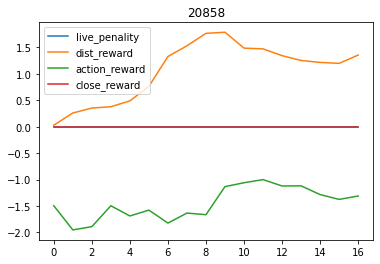

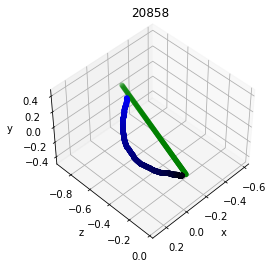

| eval  | E: 567 | S: 20858 | R: -6.6333
| train | E: 568 | S: 20858 | R: -17.3205 | D: 32.9 s | BR: -1.1176 | ALOSS: 15.5504 | CLOSS: 3.8256 | TLOSS: -0.6529 | TVAL: 0.0249 | AENT: -5.0000
| train | E: 569 | S: 20876 | R: -25.0823 | D: 44.5 s | BR: -1.1307 | ALOSS: 15.7895 | CLOSS: 4.3353 | TLOSS: 0.1389 | TVAL: 0.0249 | AENT: -5.0000
| train | E: 570 | S: 20920 | R: -38.3774 | D: 57.5 s | BR: -1.1261 | ALOSS: 15.4800 | CLOSS: 4.0386 | TLOSS: -0.0456 | TVAL: 0.0249 | AENT: -5.0000
| train | E: 571 | S: 20944 | R: -13.2531 | D: 19.4 s | BR: -1.0896 | ALOSS: 15.2196 | CLOSS: 4.1059 | TLOSS: 1.1756 | TVAL: 0.0249 | AENT: -5.0000
| train | E: 572 | S: 20962 | R: -11.1488 | D: 23.1 s | BR: -1.1348 | ALOSS: 15.3417 | CLOSS: 3.3730 | TLOSS: -0.1476 | TVAL: 0.0250 | AENT: -5.0000
| train | E: 573 | S: 20984 | R: -12.1399 | D: 26.7 s | BR: -1.1218 | ALOSS: 14.8245 | CLOSS: 2.3789 | TLOSS: 0.9664 | TVAL: 0.0250 | AENT: -5.0000
| train | E: 574 | S: 21004 | R: -11.6356 | D: 24.9 s | BR: -1.1691 

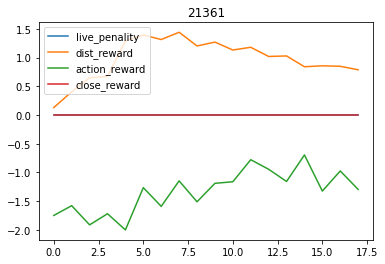

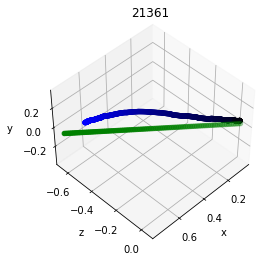

| eval  | E: 590 | S: 21361 | R: -6.5142
| train | E: 591 | S: 21361 | R: -16.5695 | D: 28.9 s | BR: -1.1171 | ALOSS: 15.1075 | CLOSS: 5.0007 | TLOSS: -0.4013 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 592 | S: 21378 | R: -5.6365 | D: 45.1 s | BR: -1.1235 | ALOSS: 14.9200 | CLOSS: 3.7401 | TLOSS: 0.4378 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 593 | S: 21391 | R: -0.6545 | D: 17.3 s | BR: -1.1495 | ALOSS: 15.3502 | CLOSS: 3.9461 | TLOSS: -0.3107 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 594 | S: 21413 | R: -13.7748 | D: 23.9 s | BR: -1.0832 | ALOSS: 14.5675 | CLOSS: 4.1291 | TLOSS: -0.0625 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 595 | S: 21447 | R: -50.7949 | D: 38.2 s | BR: -1.1055 | ALOSS: 14.9306 | CLOSS: 3.2123 | TLOSS: 0.1653 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 596 | S: 21469 | R: -12.2075 | D: 26.4 s | BR: -1.1398 | ALOSS: 15.1293 | CLOSS: 3.7343 | TLOSS: -0.5425 | TVAL: 0.0253 | AENT: -5.0000
| train | E: 597 | S: 21511 | R: -49.9465 | D: 50.1 s | BR: -1.1172 |

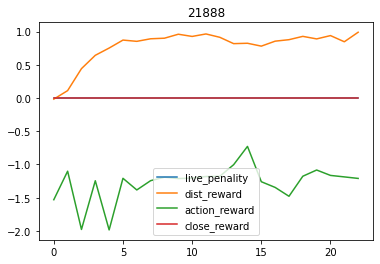

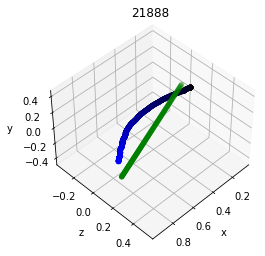

| eval  | E: 610 | S: 21888 | R: -11.3159
| train | E: 611 | S: 21888 | R: -44.4818 | D: 50.0 s | BR: -1.1105 | ALOSS: 14.4662 | CLOSS: 2.6867 | TLOSS: 0.3831 | TVAL: 0.0255 | AENT: -5.0000
| train | E: 612 | S: 21915 | R: -27.2289 | D: 52.4 s | BR: -1.1233 | ALOSS: 14.2223 | CLOSS: 3.9709 | TLOSS: 0.1837 | TVAL: 0.0255 | AENT: -5.0000
| train | E: 613 | S: 21941 | R: -21.4999 | D: 32.5 s | BR: -1.0990 | ALOSS: 14.6340 | CLOSS: 2.6195 | TLOSS: -0.0055 | TVAL: 0.0256 | AENT: -5.0000
| train | E: 614 | S: 21962 | R: -11.3057 | D: 27.2 s | BR: -1.1157 | ALOSS: 14.7661 | CLOSS: 2.5544 | TLOSS: 0.7139 | TVAL: 0.0256 | AENT: -5.0000
| train | E: 615 | S: 21982 | R: -9.3162 | D: 24.9 s | BR: -1.1379 | ALOSS: 14.4977 | CLOSS: 3.1281 | TLOSS: 0.0088 | TVAL: 0.0257 | AENT: -5.0000
| train | E: 616 | S: 21996 | R: -2.0803 | D: 17.2 s | BR: -1.1221 | ALOSS: 14.9869 | CLOSS: 3.8858 | TLOSS: 1.9915 | TVAL: 0.0257 | AENT: -5.0000
| train | E: 617 | S: 22012 | R: -4.9921 | D: 20.2 s | BR: -1.0864 | AL

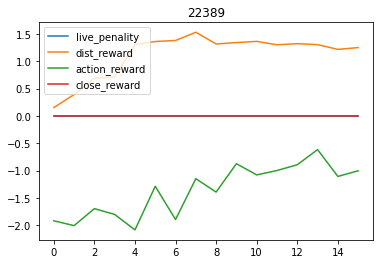

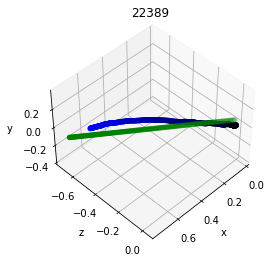

| eval  | E: 633 | S: 22389 | R: -3.9048
| train | E: 634 | S: 22389 | R: -9.1555 | D: 24.8 s | BR: -1.0393 | ALOSS: 13.2521 | CLOSS: 2.7860 | TLOSS: 0.3236 | TVAL: 0.0261 | AENT: -5.0000
| train | E: 635 | S: 22421 | R: -32.8114 | D: 49.5 s | BR: -1.1018 | ALOSS: 14.1163 | CLOSS: 3.3238 | TLOSS: 0.2354 | TVAL: 0.0261 | AENT: -5.0000
| train | E: 636 | S: 22462 | R: -40.3598 | D: 49.6 s | BR: -1.1098 | ALOSS: 14.2552 | CLOSS: 3.2088 | TLOSS: 0.1953 | TVAL: 0.0262 | AENT: -5.0000
| train | E: 637 | S: 22479 | R: -27.5657 | D: 20.6 s | BR: -1.0887 | ALOSS: 14.1910 | CLOSS: 3.7181 | TLOSS: -0.5854 | TVAL: 0.0262 | AENT: -5.0000
| train | E: 638 | S: 22499 | R: -13.8561 | D: 24.6 s | BR: -1.0993 | ALOSS: 13.8072 | CLOSS: 3.8184 | TLOSS: -0.8109 | TVAL: 0.0261 | AENT: -5.0000
| train | E: 639 | S: 22522 | R: -16.9374 | D: 27.0 s | BR: -1.1041 | ALOSS: 14.1715 | CLOSS: 3.5989 | TLOSS: 0.3923 | TVAL: 0.0261 | AENT: -5.0000
| train | E: 640 | S: 22540 | R: -5.5932 | D: 23.4 s | BR: -1.1109 | A

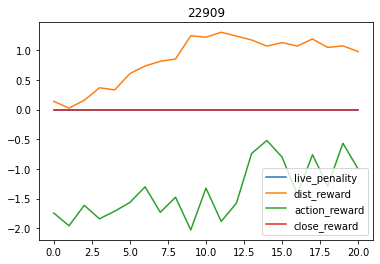

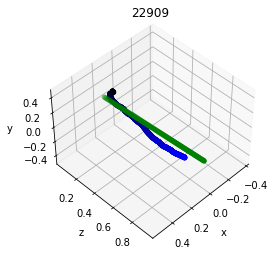

| eval  | E: 650 | S: 22909 | R: -11.1172
| train | E: 651 | S: 22909 | R: -21.9674 | D: 26.3 s | BR: -1.0884 | ALOSS: 13.9177 | CLOSS: 3.6426 | TLOSS: 0.2941 | TVAL: 0.0268 | AENT: -5.0000
| train | E: 652 | S: 22950 | R: -51.9751 | D: 74.0 s | BR: -1.1083 | ALOSS: 13.8831 | CLOSS: 2.9848 | TLOSS: 0.1882 | TVAL: 0.0269 | AENT: -5.0000
| train | E: 653 | S: 22965 | R: -5.0989 | D: 19.5 s | BR: -1.1001 | ALOSS: 13.6807 | CLOSS: 3.8927 | TLOSS: -0.5917 | TVAL: 0.0269 | AENT: -5.0000
| train | E: 654 | S: 22987 | R: -11.7445 | D: 29.3 s | BR: -1.0925 | ALOSS: 13.9177 | CLOSS: 3.5894 | TLOSS: -0.9485 | TVAL: 0.0269 | AENT: -5.0000
| train | E: 655 | S: 23006 | R: -8.3161 | D: 26.8 s | BR: -1.1014 | ALOSS: 14.0649 | CLOSS: 2.6491 | TLOSS: 0.9763 | TVAL: 0.0268 | AENT: -5.0000
| train | E: 656 | S: 23024 | R: -8.4643 | D: 22.9 s | BR: -1.0981 | ALOSS: 14.1682 | CLOSS: 2.5176 | TLOSS: 0.3994 | TVAL: 0.0268 | AENT: -5.0000
| train | E: 657 | S: 23049 | R: -16.3544 | D: 31.3 s | BR: -1.1002 | A

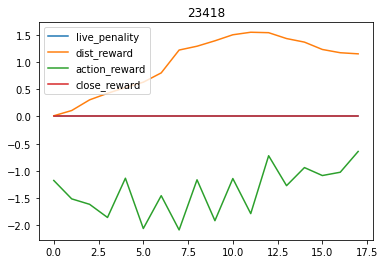

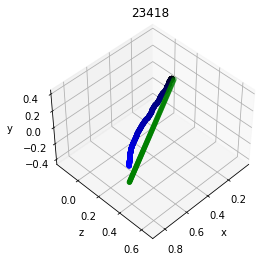

| eval  | E: 672 | S: 23418 | R: -6.9297
| train | E: 673 | S: 23418 | R: -15.7158 | D: 23.7 s | BR: -1.1072 | ALOSS: 13.8853 | CLOSS: 4.1905 | TLOSS: -0.6965 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 674 | S: 23449 | R: -31.3199 | D: 58.5 s | BR: -1.0883 | ALOSS: 13.4047 | CLOSS: 3.5694 | TLOSS: 0.3923 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 675 | S: 23465 | R: -4.4673 | D: 19.5 s | BR: -1.1032 | ALOSS: 14.1209 | CLOSS: 4.8166 | TLOSS: -0.4041 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 676 | S: 23481 | R: -6.2364 | D: 20.1 s | BR: -1.0969 | ALOSS: 13.8494 | CLOSS: 5.1532 | TLOSS: -0.3550 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 677 | S: 23499 | R: -6.2343 | D: 22.0 s | BR: -1.0698 | ALOSS: 13.0265 | CLOSS: 4.9413 | TLOSS: -0.2090 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 678 | S: 23515 | R: -3.9872 | D: 19.8 s | BR: -1.0624 | ALOSS: 13.1222 | CLOSS: 3.6986 | TLOSS: -0.6143 | TVAL: 0.0270 | AENT: -5.0000
| train | E: 679 | S: 23530 | R: -5.5647 | D: 19.5 s | BR: -1.0686 | A

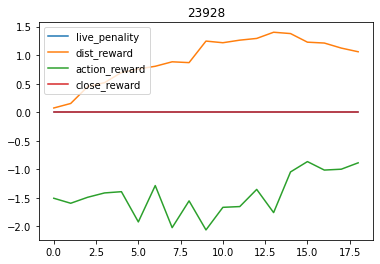

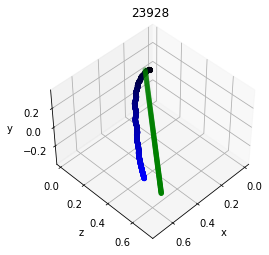

| eval  | E: 694 | S: 23928 | R: -9.8482
| train | E: 695 | S: 23928 | R: -4.5653 | D: 19.4 s | BR: -1.1125 | ALOSS: 13.6172 | CLOSS: 3.2690 | TLOSS: 1.2354 | TVAL: 0.0272 | AENT: -5.0000
| train | E: 696 | S: 23973 | R: -46.9467 | D: 81.6 s | BR: -1.0959 | ALOSS: 13.2770 | CLOSS: 3.0309 | TLOSS: 0.2009 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 697 | S: 24020 | R: -60.0726 | D: 58.1 s | BR: -1.0780 | ALOSS: 13.3082 | CLOSS: 2.7487 | TLOSS: -0.2511 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 698 | S: 24035 | R: -6.7724 | D: 19.9 s | BR: -1.0649 | ALOSS: 13.0310 | CLOSS: 2.6735 | TLOSS: -0.2926 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 699 | S: 24055 | R: -8.5459 | D: 25.4 s | BR: -1.1357 | ALOSS: 13.7670 | CLOSS: 4.4127 | TLOSS: -0.0854 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 700 | S: 24074 | R: -13.3304 | D: 23.9 s | BR: -1.0663 | ALOSS: 12.9715 | CLOSS: 3.9944 | TLOSS: 0.5875 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 701 | S: 24088 | R: -4.5650 | D: 18.1 s | BR: -1.0745 | AL

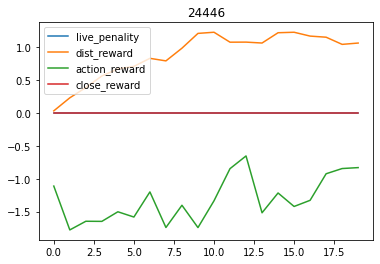

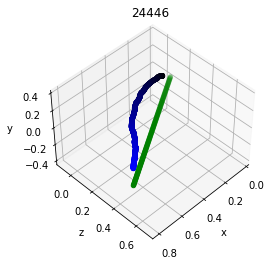

| eval  | E: 714 | S: 24446 | R: -8.5325
| train | E: 715 | S: 24446 | R: -9.3445 | D: 23.6 s | BR: -1.0487 | ALOSS: 12.9642 | CLOSS: 4.2676 | TLOSS: -0.1712 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 716 | S: 24486 | R: -40.6621 | D: 70.7 s | BR: -1.0790 | ALOSS: 13.2325 | CLOSS: 3.1699 | TLOSS: 0.0985 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 717 | S: 24507 | R: -14.7559 | D: 26.5 s | BR: -1.0778 | ALOSS: 12.8393 | CLOSS: 4.4240 | TLOSS: -1.2429 | TVAL: 0.0275 | AENT: -5.0000
| train | E: 718 | S: 24537 | R: -28.8418 | D: 36.9 s | BR: -1.1101 | ALOSS: 13.2177 | CLOSS: 2.5931 | TLOSS: -0.5255 | TVAL: 0.0274 | AENT: -5.0000
| train | E: 719 | S: 24566 | R: -28.5595 | D: 35.0 s | BR: -1.0574 | ALOSS: 12.6574 | CLOSS: 4.3517 | TLOSS: 0.5986 | TVAL: 0.0274 | AENT: -5.0000
| train | E: 720 | S: 24594 | R: -24.0320 | D: 33.4 s | BR: -1.0608 | ALOSS: 12.8989 | CLOSS: 2.7936 | TLOSS: -0.3802 | TVAL: 0.0274 | AENT: -5.0000
| train | E: 721 | S: 24616 | R: -11.4263 | D: 26.1 s | BR: -1.0859 

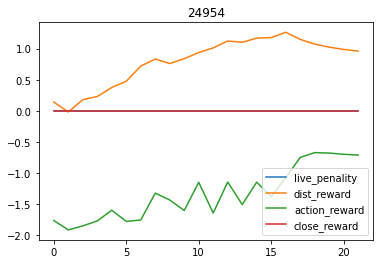

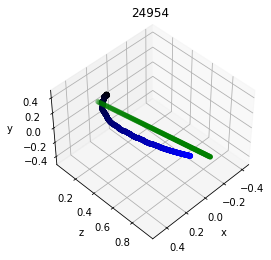

| eval  | E: 735 | S: 24954 | R: -11.8938
| train | E: 736 | S: 24954 | R: -14.9253 | D: 29.5 s | BR: -1.0291 | ALOSS: 12.6107 | CLOSS: 3.8482 | TLOSS: 0.0156 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 737 | S: 24974 | R: -9.9556 | D: 51.0 s | BR: -1.0872 | ALOSS: 13.0362 | CLOSS: 4.0191 | TLOSS: 0.3301 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 738 | S: 24993 | R: -6.9064 | D: 23.2 s | BR: -1.0740 | ALOSS: 12.9030 | CLOSS: 3.1147 | TLOSS: 0.8498 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 739 | S: 25015 | R: -12.6164 | D: 27.6 s | BR: -1.0815 | ALOSS: 12.6917 | CLOSS: 3.7903 | TLOSS: -0.7244 | TVAL: 0.0277 | AENT: -5.0000
| train | E: 740 | S: 25036 | R: -11.0697 | D: 25.8 s | BR: -1.0598 | ALOSS: 13.1784 | CLOSS: 4.9996 | TLOSS: -0.2036 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 741 | S: 25057 | R: -8.9078 | D: 25.7 s | BR: -1.0766 | ALOSS: 13.1167 | CLOSS: 3.4643 | TLOSS: 0.3425 | TVAL: 0.0276 | AENT: -5.0000
| train | E: 742 | S: 25076 | R: -7.6079 | D: 22.8 s | BR: -1.0680 | AL

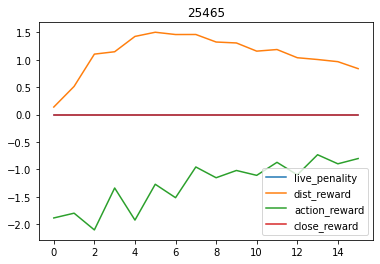

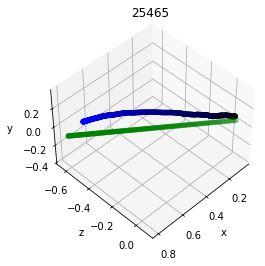

| eval  | E: 758 | S: 25465 | R: -2.9352
| train | E: 759 | S: 25465 | R: -13.2115 | D: 22.5 s | BR: -1.0739 | ALOSS: 13.0738 | CLOSS: 3.8526 | TLOSS: 0.6780 | TVAL: 0.0281 | AENT: -5.0000
| train | E: 760 | S: 25515 | R: -65.5307 | D: 79.1 s | BR: -1.0729 | ALOSS: 12.8151 | CLOSS: 3.1764 | TLOSS: 0.4161 | TVAL: 0.0283 | AENT: -5.0000
| train | E: 761 | S: 25540 | R: -18.2332 | D: 29.3 s | BR: -1.0728 | ALOSS: 12.8136 | CLOSS: 4.4843 | TLOSS: 1.1344 | TVAL: 0.0284 | AENT: -5.0000
| train | E: 762 | S: 25561 | R: -11.4116 | D: 27.8 s | BR: -1.0568 | ALOSS: 12.6096 | CLOSS: 4.2460 | TLOSS: 0.4430 | TVAL: 0.0285 | AENT: -5.0000
| train | E: 763 | S: 25575 | R: -2.9959 | D: 18.0 s | BR: -1.0661 | ALOSS: 12.8521 | CLOSS: 3.6939 | TLOSS: 0.3036 | TVAL: 0.0286 | AENT: -5.0000
| train | E: 764 | S: 25607 | R: -26.1435 | D: 38.2 s | BR: -1.0630 | ALOSS: 12.6929 | CLOSS: 3.3540 | TLOSS: -0.2008 | TVAL: 0.0286 | AENT: -5.0000
| train | E: 765 | S: 25642 | R: -28.9267 | D: 40.7 s | BR: -1.0397 | A

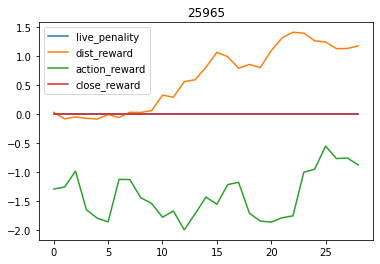

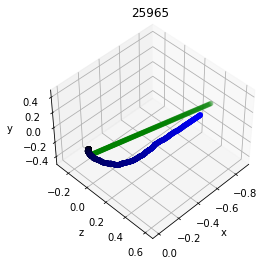

| eval  | E: 779 | S: 25965 | R: -22.4547
| train | E: 780 | S: 25965 | R: -8.1778 | D: 26.2 s | BR: -1.0304 | ALOSS: 12.4437 | CLOSS: 2.8708 | TLOSS: -0.4354 | TVAL: 0.0284 | AENT: -5.0000
| train | E: 781 | S: 25989 | R: -18.2371 | D: 56.4 s | BR: -1.0694 | ALOSS: 12.6597 | CLOSS: 2.7440 | TLOSS: -0.3040 | TVAL: 0.0283 | AENT: -5.0000
| train | E: 782 | S: 26011 | R: -11.8823 | D: 27.8 s | BR: -1.0461 | ALOSS: 12.6766 | CLOSS: 3.4954 | TLOSS: 0.1941 | TVAL: 0.0283 | AENT: -5.0000
| train | E: 783 | S: 26032 | R: -8.2277 | D: 25.3 s | BR: -1.0963 | ALOSS: 13.0359 | CLOSS: 3.9238 | TLOSS: -0.5101 | TVAL: 0.0283 | AENT: -5.0000
| train | E: 784 | S: 26057 | R: -17.5849 | D: 30.3 s | BR: -1.0416 | ALOSS: 12.2539 | CLOSS: 3.3911 | TLOSS: -1.0372 | TVAL: 0.0282 | AENT: -5.0000
| train | E: 785 | S: 26084 | R: -19.8517 | D: 32.2 s | BR: -1.0169 | ALOSS: 12.4980 | CLOSS: 4.0245 | TLOSS: 0.0978 | TVAL: 0.0281 | AENT: -5.0000
| train | E: 786 | S: 26105 | R: -10.6641 | D: 26.0 s | BR: -1.0742 

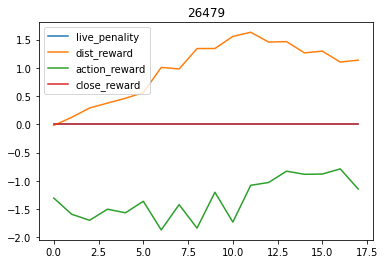

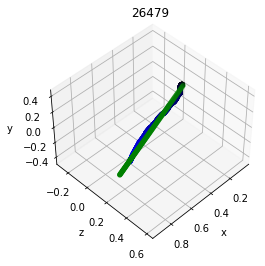

| eval  | E: 802 | S: 26479 | R: -6.3762
| train | E: 803 | S: 26479 | R: -17.6389 | D: 31.7 s | BR: -1.0520 | ALOSS: 12.6896 | CLOSS: 3.5939 | TLOSS: -0.2632 | TVAL: 0.0281 | AENT: -5.0000
| train | E: 804 | S: 26508 | R: -21.5310 | D: 56.2 s | BR: -1.0205 | ALOSS: 12.2977 | CLOSS: 3.8591 | TLOSS: -0.0945 | TVAL: 0.0280 | AENT: -5.0000
| train | E: 805 | S: 26528 | R: -12.3780 | D: 19.5 s | BR: -1.0495 | ALOSS: 12.1808 | CLOSS: 3.2129 | TLOSS: -0.3323 | TVAL: 0.0280 | AENT: -5.0000
| train | E: 806 | S: 26546 | R: -8.3984 | D: 22.5 s | BR: -1.0207 | ALOSS: 12.5837 | CLOSS: 4.7290 | TLOSS: 0.5526 | TVAL: 0.0280 | AENT: -5.0000
| train | E: 807 | S: 26566 | R: -9.5450 | D: 24.0 s | BR: -1.0642 | ALOSS: 12.8706 | CLOSS: 3.3538 | TLOSS: 0.9075 | TVAL: 0.0281 | AENT: -5.0000
| train | E: 808 | S: 26588 | R: -11.6217 | D: 27.0 s | BR: -1.0825 | ALOSS: 13.1522 | CLOSS: 3.1256 | TLOSS: 0.5854 | TVAL: 0.0282 | AENT: -5.0000
| train | E: 809 | S: 26610 | R: -11.8513 | D: 25.7 s | BR: -1.0893 | 

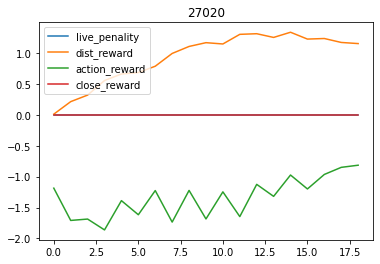

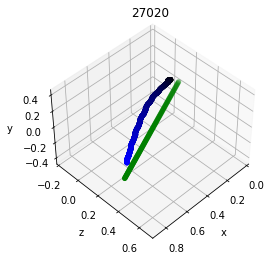

| eval  | E: 824 | S: 27020 | R: -7.8223
| train | E: 825 | S: 27020 | R: -42.4080 | D: 57.6 s | BR: -1.0499 | ALOSS: 12.3674 | CLOSS: 2.9922 | TLOSS: 0.0904 | TVAL: 0.0272 | AENT: -5.0000
| train | E: 826 | S: 27038 | R: -6.7650 | D: 45.6 s | BR: -1.0429 | ALOSS: 12.2371 | CLOSS: 3.0388 | TLOSS: 0.1863 | TVAL: 0.0272 | AENT: -5.0000
| train | E: 827 | S: 27054 | R: -4.4396 | D: 14.1 s | BR: -1.0486 | ALOSS: 12.3354 | CLOSS: 2.2205 | TLOSS: 0.6380 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 828 | S: 27097 | R: -43.1369 | D: 49.7 s | BR: -1.0652 | ALOSS: 12.3860 | CLOSS: 2.8235 | TLOSS: -0.2180 | TVAL: 0.0273 | AENT: -5.0000
| train | E: 829 | S: 27128 | R: -21.1175 | D: 39.3 s | BR: -1.0433 | ALOSS: 12.5189 | CLOSS: 3.2539 | TLOSS: -0.6633 | TVAL: 0.0272 | AENT: -5.0000
| train | E: 830 | S: 27148 | R: -9.6638 | D: 24.2 s | BR: -1.0460 | ALOSS: 12.3124 | CLOSS: 4.7659 | TLOSS: -0.4059 | TVAL: 0.0271 | AENT: -5.0000
| train | E: 831 | S: 27166 | R: -6.6123 | D: 21.8 s | BR: -1.0443 | AL

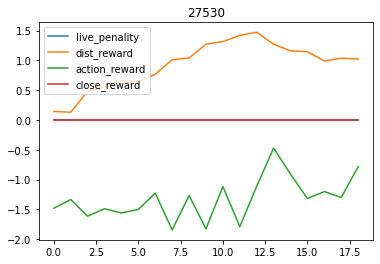

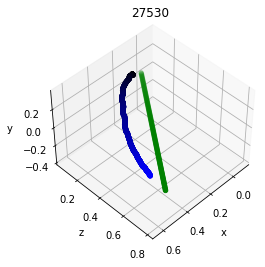

| eval  | E: 845 | S: 27530 | R: -7.6188
| train | E: 846 | S: 27530 | R: -5.5983 | D: 21.7 s | BR: -1.0379 | ALOSS: 12.2588 | CLOSS: 3.1615 | TLOSS: 0.1818 | TVAL: 0.0278 | AENT: -5.0000
| train | E: 847 | S: 27557 | R: -20.9638 | D: 58.2 s | BR: -1.0462 | ALOSS: 11.9533 | CLOSS: 3.8973 | TLOSS: 0.5427 | TVAL: 0.0278 | AENT: -5.0000
| train | E: 848 | S: 27577 | R: -13.1171 | D: 25.6 s | BR: -1.0527 | ALOSS: 12.1631 | CLOSS: 3.1859 | TLOSS: -0.0120 | TVAL: 0.0279 | AENT: -5.0000
| train | E: 849 | S: 27593 | R: -6.2129 | D: 19.8 s | BR: -1.0382 | ALOSS: 12.2160 | CLOSS: 3.0048 | TLOSS: 0.4640 | TVAL: 0.0279 | AENT: -5.0000
| train | E: 850 | S: 27610 | R: -7.7334 | D: 14.6 s | BR: -1.0381 | ALOSS: 12.1030 | CLOSS: 4.5132 | TLOSS: 0.0715 | TVAL: 0.0280 | AENT: -5.0000
| train | E: 851 | S: 27632 | R: -14.9074 | D: 25.6 s | BR: -1.0455 | ALOSS: 12.1996 | CLOSS: 5.0788 | TLOSS: -0.2160 | TVAL: 0.0280 | AENT: -5.0000
| train | E: 852 | S: 27651 | R: -9.6150 | D: 22.5 s | BR: -1.0571 | ALO

KeyboardInterrupt: 

In [27]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [28]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [29]:
network_folder

'/root/pytorch_fish/output_data/2021-06-08/test flatfish can it turn?_2021-06-08 03:09/networks/'

## Evaluation and Test

In [ ]:
evaluate_save_fluid=True
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
#         env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            action = agent.predict(obs, deterministic=True)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(0,0.01)

In [30]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

True

In [31]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [32]:
%matplotlib notebook

In [33]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

<IPython.core.display.Javascript object>


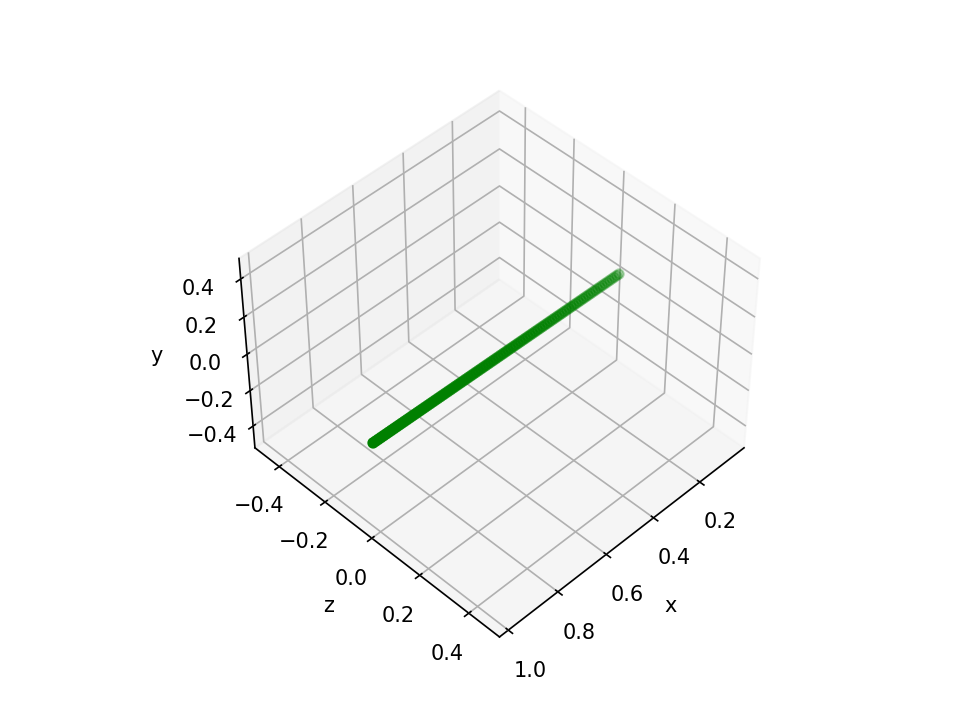

In [34]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,control_dt=control_dt,radius=radius,
                       theta=np.array([0,0]),action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
                   )
env.plot3d()

<IPython.core.display.Javascript object>


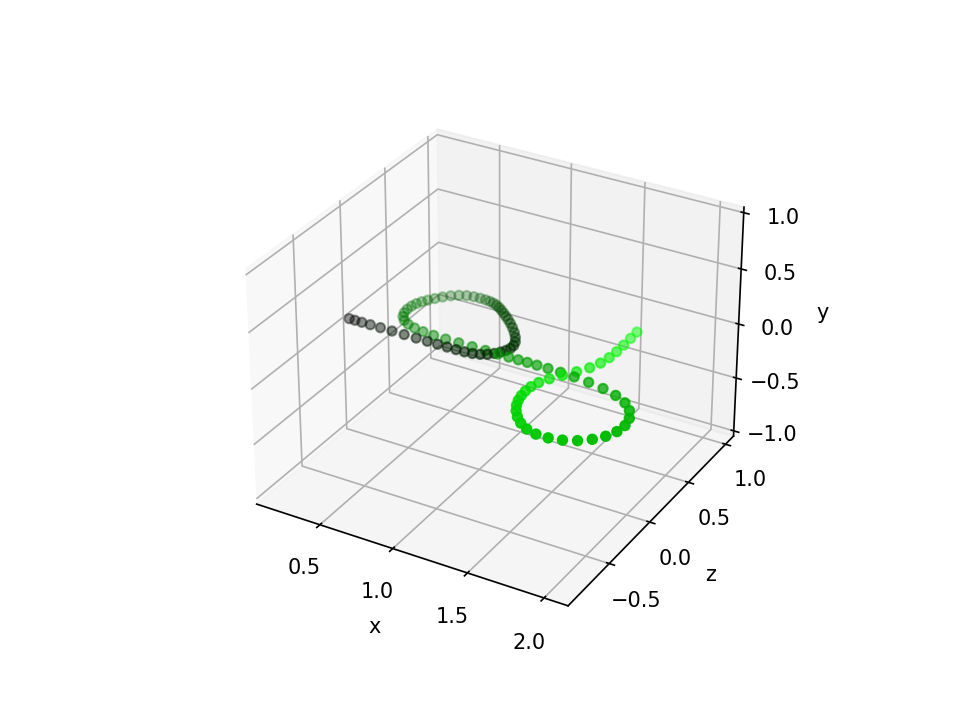

In [35]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_69.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [36]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


<IPython.core.display.Javascript object>


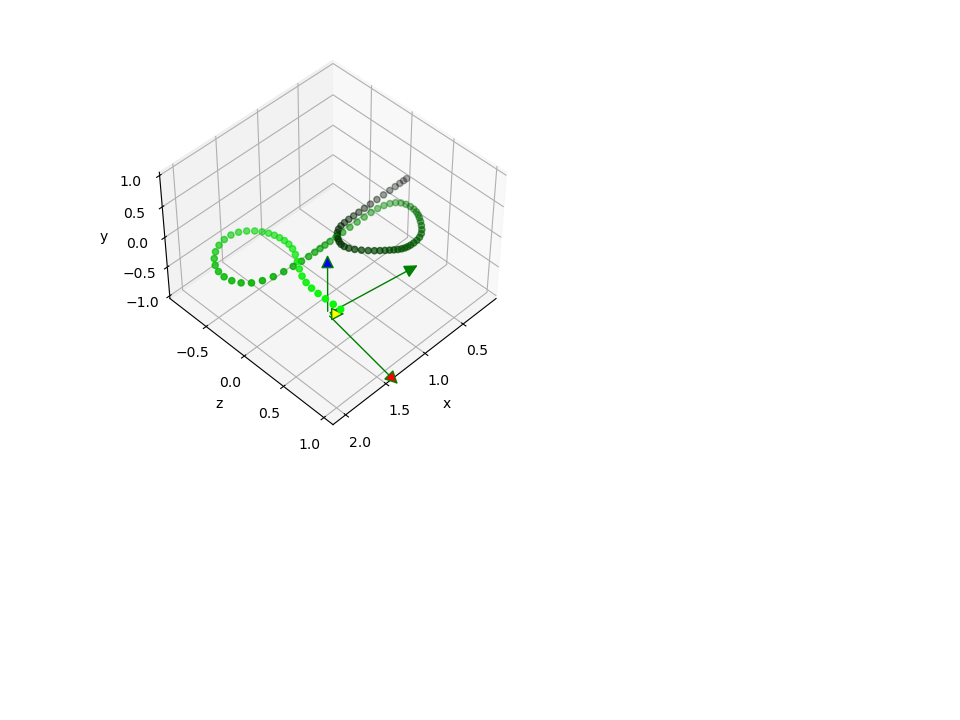

Time exceed!  1.041 0.9833333333333333 44.6035041809082


In [38]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)




env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action = agent.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=False)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.15:
        t = t+dt
        env.goal_pos = traj.getPose(t).getPosition() 
        env.path_start  = env.body_xyz 
        env.path_dir = env.goal_pos-env.path_start
        env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**0.5) for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()